In [7]:
# !open .

In [8]:
# %load py_neo_quant_backbone.py
# %load py_neo_quant_backbone.py
# !open .
import os
import pandas as pd
import numpy as np
import requests
import bs4
import time
import datetime
import matplotlib.pyplot as plt
from dateutil import parser
from matplotlib import font_manager, rc
from IPython.display import HTML
pd.set_option('display.max_colwidth', -1)
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# %matplotlib inline


def file_exists(file_path):
    return os.path.exists(file_path)

def remove_file(file_path):
    os.remove(file_path)

def make_code(x):
    x = str(x)
    code = '0' * (6-len(x)) + x
    if not code.startswith('A'):
        code = 'A' + code
    return code


def make_code2(x):
    x = str(x)
    return '0' * (6-len(x)) + x

# def get_all_company_info():
#     kospi = pd.read_excel('data/kospi.xls')
#     kosdaq = pd.read_excel('data/kosdaq.xls')
#     kospi['구분'] = '코스피'
#     kosdaq['구분'] = '코스닥'
#     companies = pd.concat([kospi, kosdaq])
#     companies = companies[['구분','종목코드','기업명']]
# #     companies['종목코드'] = companies['종목코드'].apply(modifyCompanyCode)
#     companies = companies.reset_index()
#     return companies

def company_apply_a_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code)
    return companies.set_index(new_index)

def company_apply_no_prefix(companies):
    old_index = pd.Series(companies.index)
    new_index = old_index.map(make_code2)
    return companies.set_index(new_index)

def remove_a_from_company_code(company_df):
    code_list = []
    for code in company_df.index:
        code = code.replace('A','')
        code_list.append(code)
    return company_df.set_index(pd.Series(code_list))

def _get_firm_list_existing_in_price_df(firm_list, price_df):
    new_firm_list = []
    for code in firm_list:
        if code in price_df.columns:
            new_firm_list.append(code)
    return new_firm_list

def get_company_data(min_price=0):
    kospi = pd.read_excel('data/kospi.xls')
    kosdaq = pd.read_excel('data/kosdaq.xls')
    kospi['구분'] = '코스피'
    kosdaq['구분'] = '코스닥'
    companies = pd.concat([kospi, kosdaq], sort=False)
    companies = companies[['종목코드','기업명','구분','업종코드','업종','액면가(원)','상장주식수(주)', '자본금(원)']]
    companies['상장주식수(주)'] = companies['상장주식수(주)'].str.replace(',','').astype(int)
    companies['자본금(원)'] = companies['자본금(원)'].str.replace(',','').astype(int)
    companies['액면가(원)'] = companies['액면가(원)'].str.replace(',','').astype(float)
    companies = companies[companies['액면가(원)'] >= min_price]
    companies['액면가(원)'] = companies['액면가(원)'].astype(int)
    companies = companies.set_index('종목코드')
    companies = company_apply_a_prefix(companies)
    return companies

def get_price_data():
    price_path = r'data/price_data_2013.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
#     price_df.columns = 'A' + price_df.columns 
    return price_df

def get_fs_data():
    fs_path = r'data/fs_data.xlsx'
    return get_finance_data(fs_path)

def get_fr_data():
    fr_path = r'data/fr_data.xlsx'
    return get_finance_data(fr_path)

def get_invest_data():
    invest_path = r'data/invest_data.xlsx'
    return get_finance_data(invest_path)

def get_company_df_from_total_capital(company_df, pct, start_date = None):
    company_df = add_price_info(company_df, start_date)
    company_df['시가총액'] = company_df['상장주식수(주)'] * company_df['price']
    return company_df.sort_values(by='시가총액', ascending=False)[:int(len(company_df) * pct)]

def load_all_data():
    companies = get_company_data()
    fs_df = get_fs_data()
    fr_df = get_fr_data()
    iv_df = get_invest_data()
    prices = get_price_data()
    return companies, fs_df, fr_df, iv_df, prices 

# 액면가 1000원 이상 회사 리스트 가져와서 코드앞에 A 붙이기
# companies = get_company_info(1000)
# companies = apply_a_type_code(companies)

def filter_company(st_df, companies):
    new_company_list = []
    for num, code in enumerate(st_df.index):
        if code in companies.index:
            new_company_list.append(code)

    return st_df.loc[new_company_list]

# def _get_price_over_list(company_code_list, price_df, check_date=None, min_price = 0):
#     if check_date == None:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
#     else:
#         temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[-1]})
#     temp_df = temp_df[temp_df['price'] > min_price]
#     return temp_df.index

def _get_price_over_code_list(company_code_list, price_df, min_price = 0, check_month=None):
    if check_month == None:
        temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    else:
        if check_month in price_df.index:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].loc[check_month].iloc[-1]})
        else:
            temp_df = pd.DataFrame({'price':price_df[company_code_list].iloc[-1]})
    temp_df = temp_df[temp_df['price'] > min_price]
    return temp_df.index

def _add_company_info(st_df, company_df):
    return pd.merge(st_df, company_df, how='inner', left_index=True, right_index=True)

def _add_price_info(st_df, price_df, start_date = None):
    if start_date == None:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].iloc[-1]}) 
    else:
        temp_df = pd.DataFrame({'price':price_df[st_df.index].loc[start_date:].iloc[0]}) 
    return pd.merge(st_df, temp_df, how='left', left_index=True, right_index=True)

# str 이나 list 를 전달한다.
def _get_company_code_list(company_name_list, company_df):
    code_list = []
    if isinstance(company_name_list, str):
        company_name_list = [company_name_list]
    for company_name in company_name_list:
        for num, name in enumerate(company_df['기업명']):
            if company_name in name:
                code_list.append({'code':company_df.index[num], 'name':name})
    return code_list

def _get_company_code(name, company_df):
    return company_df[company_df['기업명']==name].index[0]

def _get_company_name(company_code, company_df):
    return company_df.loc[company_code]['기업명']

def _show_chart(company_code, price_df, company_df, start_date, end_date, show_market_price=False, name=None):
    if isinstance(company_code, str):
        strategy_price = price_df[company_code][start_date:end_date]
        strategy_df = pd.DataFrame({'price':strategy_price})
        
        plt.figure(figsize=(10, 6))
        if name == None:
            name = _get_company_name(company_code, company_df)
        strategy_df['price'].plot(label=name)
        
        if show_market_price == True:
            if is_kospi(company_code):
                market_name = 'KOSPI'
            else:
                market_name = 'KOSDAQ'
            market_price = price_df[market_name][start_date:end_date]
            market_df = pd.DataFrame({'price':market_price})
            ratio = strategy_df.iloc[0]/market_df.iloc[0]
            market_df = market_df * ratio
            market_df['price'].plot(label=market_name)
        
        plt.legend()
        plt.show() 
    else:
        plt.rc('font', size=20)
        company_code_list = company_code
        strategy_price = price_df[company_code_list][start_date:end_date]
        num_row = int((len(company_code_list)-1)/2)+1
        plt.figure(figsize=(10*4, (num_row)*5))
        plt.subplots_adjust(wspace=0.2, hspace=0.4)
        for i, code in enumerate(company_code_list):
            ax = plt.subplot(num_row, 4, i+1)
            name = _get_company_name(code, company_df)
            ax.title.set_text(name + ' (' + str(code) + ')')
            ax.plot(strategy_price.index, strategy_price[code], color='black')

            if show_market_price == True:
                if is_kospi(code):
                    market_name = 'KOSPI'
                else:
                    market_name = 'KOSDAQ'
                market_price = price_df[market_name][start_date:end_date]
                market_df = pd.DataFrame({'price':market_price})
                ratio = strategy_price[code].iloc[0]/market_df.iloc[0]
                market_df = market_df * ratio
                ax.plot(market_df.index, market_df['price'], color='red')
        plt.show()

    
# def _show_chart_by_name(company_name, company_df, price_df, year_duration=1):
#     company_list = _get_company_code_list(company_name, company_df)
#     if len(company_list) == 0:
#         print('no company with name' + company_name)
#         return
#     code = company_list[0]['code']
#     name = company_list[0]['name']
#     _show_chart(code, company_df, price_df, year_duration, name) 
    
def _show_monthly_chart(company_code, company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")
    
    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
#             print(year_month)
            if year_month in price_df.index:
                temp_df = pd.DataFrame(price_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)

    strategy_df = pd.DataFrame({'price':month_df[company_code]})
    ma3 = strategy_df['price'].rolling(window=3).mean()
    strategy_df['ma3'] = ma3

#     plt.figure(figsize=(10, 6))
    name = _get_company_name(company_code, company_df)
#     strategy_df['price'].plot(label=name)

    plt.figure(figsize=(20, 12))
    
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma3'], color='red', label='ma3')

    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 

    
def _show_multi_chart(company_code_list, price_df, company_df, start_date, end_date):
#     end_date = price_df.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code_list][start_date:end_date]
    num_row = int((len(company_code_list)-1)/2)+1
    plt.figure(figsize=(10, num_row*5))
    for i, code in enumerate(company_code_list):
        ax = plt.subplot(num_row, 4, i+1)
        name = _get_company_name(code, company_df)
        ax.title.set_text(name)
        ax.plot(strategy_price.index, strategy_price[code])
    plt.show()


def _show_detail_chart(company_code, company_df, price_df, year_duration=1, name=None):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
#     strategy_df
    ma5 = strategy_df['price'].rolling(window=5).mean()
    strategy_df['ma5'] = ma5
    ma10 = strategy_df['price'].rolling(window=10).mean()
    strategy_df['ma10'] = ma10
    ma20 = strategy_df['price'].rolling(window=20).mean()
    strategy_df['ma20'] = ma20
    ma60 = strategy_df['price'].rolling(window=60).mean()
    strategy_df['ma60'] = ma60
    ma120 = strategy_df['price'].rolling(window=120).mean()
    strategy_df['ma120'] = ma120
    plt.figure(figsize=(20, 12))
    # strategy_df['price'].plot(label=name)
    if name == None:
        name = company_code
    plt.plot(strategy_df.index, strategy_df['price'], color='darkblue',linewidth=3.0)
    plt.plot(strategy_df.index, strategy_df['ma5'], color='red', label='ma5')
    plt.plot(strategy_df.index, strategy_df['ma10'], color='blue', label='ma10')
    plt.plot(strategy_df.index, strategy_df['ma20'], color='green', label='ma20')
    plt.plot(strategy_df.index, strategy_df['ma60'], color='cyan', label='ma60')
    plt.plot(strategy_df.index, strategy_df['ma120'], color='yellow', label='ma120')
    plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    plt.grid()
    plt.show() 
    


def _show_detail_chart_by_name(company_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(company_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    _show_detail_chart(code, company_df, price_df, year_duration, name)    
    
    
def _get_maximum_earning_rate(price_df, company_df, year_duration=1, min_price=0, min_profit=0, type='all'):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]
    
    price_diff_df = pd.DataFrame({first_price.name:first_price, last_price.name:last_price})
    price_diff_df = price_diff_df[price_diff_df[last_price.name] > min_price]
    
    price_diff_df['diff'] = price_diff_df[last_price.name] - price_diff_df[first_price.name]
#     price_diff_df = price_diff_df[price_diff_df['diff'] > 0]
    
    # price_diff_df['ratio'] = price_diff_df['diff'] / price_diff_df[first_price.name]
    price_diff_df['ratio'] = ((price_diff_df[last_price.name] / price_diff_df[first_price.name]) - 1) * 100
    price_diff_df['ratio'] = price_diff_df['ratio'].astype(int)
    
    price_diff_df = price_diff_df[price_diff_df['ratio'] > min_profit]
    
    price_diff_df = price_diff_df.sort_values(by='ratio', ascending=False)
    
    price_diff_df = _add_company_info(price_diff_df, company_df)
    
    if type == 'kospi':
        price_diff_df = get_kospi_list(price_diff_df)
    elif type == 'kosdaq':
        price_diff_df = get_kosdaq_list(price_diff_df)
        
    return price_diff_df


def _show_earning_chart(code_list, price_df, year_duration=1, initial_money=100000000):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    st_backtest = _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money)
    plt.figure(figsize=(10, 6))
    st_backtest['total_change_rate'].plot()
    plt.show()
    
def _show_company_info(company_code_list, company_df, price_df):
    firm_df = company_df.loc[company_code_list]
    firm_df = _add_price_info(firm_df, price_df)
    firm_df['fs_info'] = firm_df.index
    firm_df['fs_info'] = firm_df['fs_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode={0}" target="_blank">fs</a>'.format(x))
    firm_df['fr_info'] = firm_df.index
    firm_df['fr_info'] = firm_df['fr_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode={0}" target="_blank">fr</a>'.format(x))
    firm_df['iv_info'] = firm_df.index
    firm_df['iv_info'] = firm_df['iv_info'].apply(lambda x: '<a href="https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode={0}" target="_blank">iv</a>'.format(x))
    firm_df['chart'] = firm_df.index
    firm_df['chart'] = firm_df['chart'].apply(lambda x: x.replace('A',''))
    firm_df['chart'] = firm_df['chart'].apply(lambda x: '<a href="https://finance.naver.com/item/fchart.nhn?code={0}" target="_blank">chart</a>'.format(x))
    return HTML(firm_df.to_html(escape=False))

def _show_company_info_by_name(firm_name, company_df):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
#     company_list
    code_list = []
    for company in company_list:
        code_list.append(company['code'])
    return _show_company_info(code_list, companies)

def _show_earning_rate(company_code_list, company_df, price_df, year_duration=1):
    company_selected = companies.loc[company_code_list]

    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)
    
    strategy_price = price_df[company_code_list][start_date:end_date]
    strategy_price = strategy_price.dropna()
    strategy_price = strategy_price.fillna(method='bfill')
    last_price = strategy_price.iloc[-1]
    first_price = strategy_price.iloc[0]

    company_selected['profit'] = ((last_price/first_price - 1) * 100).astype(int)
    company_selected['profit'] = company_selected['profit'].astype(str) + ' %'
    return company_selected

def _show_earning_rate_by_name(firm_name, company_df, price_df, year_duration=1):
    company_list = _get_company_code_list(firm_name, company_df)
    if len(company_list) == 0:
        return "No Company with name : " + firm_name
    
    code_list = []
    for company in company_list:
        code_list.append(company['code'])

    return _show_earning_rate(code_list, company_df, price_df, year_duration)


def get_vaild_code_from_price_df(code_list, price_df):
    new_code_list = []
    for code in code_list:
        if code in price_df.columns:
            new_code_list.append(code)
    return new_code_list        

def _show_business_trend(company_df, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    company_df['업종코드'] = company_df['업종코드'].astype(str)
    company_df['업종구분'] = company_df['업종코드'] + ' (' + company_df['업종'] + ')'
    all_busi = company_df['업종구분'].unique()
    busi_list = []
    for busi_name in all_busi:
        temp_list = company_df[company_df['업종구분'] == busi_name]
        busi_list.append({'name':busi_name + ' - ' + str(len(temp_list)),'list':temp_list.index})

    for i, busi in enumerate(busi_list):
        busi_name = busi['name']
        busi_code_list = busi['list']
        strategy_price = price_df[get_vaild_code_from_price_df(busi_code_list, price_df)][start_date:end_date]
        strategy_price.fillna(method='bfill')
        busi_earning = strategy_price.sum(axis=1)
        temp_df = pd.DataFrame({busi_name:busi_earning})
        if i == 0:
            total_busi_earning = temp_df
        else:
            total_busi_earning = pd.merge(total_busi_earning, temp_df, how='outer', left_index=True, right_index=True)
    num_row = int((len(total_busi_earning.columns)-1)/4)+1
    plt.figure(figsize=(6*4, num_row*6))
    for i, busi in enumerate(total_busi_earning.columns):
        ax = plt.subplot(num_row, 4, i+1)
        ax.title.set_text(busi)
        ax.plot(total_busi_earning.index, total_busi_earning[busi])
    plt.show()    
    
def get_company_list_from_business_code(busi_code, company_df):
    return company_df[company_df['업종코드'] == busi_code].index





def fetch_prices(compay_code_list, timeframe, count):
    for num, code in enumerate(compay_code_list):
        try:
            print(num, code)
            time.sleep(1)
            try:
                price_df = make_price_dataframe(code, timeframe, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                price_df = make_price_dataframe(code, timeframe, count)
            if num == 0 :
                total_price = price_df
            else:
                total_price = pd.merge(total_price, price_df, how='outer', right_index=True, left_index=True)
        except ValueError:
            continue
        except KeyError:
            continue
    return total_price





# 기존 price dataframe 을 최신 가격으로 업데이트.
# ex) prices_update = update_prices(companies, prices, '10') 
# 기존 price 와 신규 price 의 차이 비교
# prices_update.merge(prices,indicator = True, left_index=True, right_index=True, how='outer').loc[lambda x : x['_merge']!='both']
def update_origin_price_df(origin_price_df, code, count):
    origin_prices = origin_price_df
    price_df = make_price_dataframe(code, 'day', count)
    price_df.index = pd.to_datetime(price_df.index)
    price_df[code] = price_df[code].astype(float)
    price_df_origin = pd.DataFrame({code:origin_prices[code]}) 
    new_price_df = pd.concat([price_df_origin, price_df], sort=False)
    new_price_df = new_price_df.loc[~new_price_df.index.duplicated(keep='last')]
    origin_prices = origin_prices.drop(code, axis=1)
    origin_prices = pd.merge(origin_prices, new_price_df, left_index=True, right_index=True, how='outer')
    return origin_prices
    
def update_prices(company_code_list, origin_price_df, count):
    origin_prices = origin_price_df
    for num, code in enumerate(company_code_list):
        try:
            print(num, code)
            time.sleep(1)
            try:
                origin_prices = update_origin_price_df(origin_prices, code, count)
            except requests.exceptions.Timeout:
                time.sleep(60)
                origin_prices = update_origin_price_df(origin_prices, code, count)
        except ValueError:
            continue
        except KeyError:
            continue
    return origin_prices

# [코드 3.15] 재무제표 데이터를 가져와 데이터프레임으로 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fs_dataframe(firm_code):
    fs_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Finance.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=103&stkGb=701&gicode=' + firm_code
    fs_page = requests.get(fs_url)
    fs_tables = pd.read_html(fs_page.text)
    
    temp_df = fs_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df[temp_df.columns[:4]]
    temp_df = temp_df.loc[['매출액', '매출원가', '영업이익', '당기순이익', '매출총이익']]

    temp_df2 = fs_tables[2]
    temp_df2 = temp_df2.set_index(temp_df2.columns[0])
    temp_df2 = temp_df2.loc[['자산', '부채', '자본']]

    temp_df3 = fs_tables[4]
    temp_df3 = temp_df3.set_index(temp_df3.columns[0])
    temp_df3 = temp_df3.loc[['영업활동으로인한현금흐름']]

    fs_df = pd.concat([temp_df, temp_df2, temp_df3], sort=False)
    
    return fs_df

# [코드 3.19] 데이터프레임 형태 바꾸기 코드 함수화 (CH3. 데이터 수집하기.ipynb)

def change_df(firm_code, dataframe):
    for num, col in enumerate(dataframe.columns):
        temp_df = pd.DataFrame({firm_code : dataframe[col]})
        temp_df = temp_df.T
        temp_df.columns = [[col]*len(dataframe), temp_df.columns]
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.merge(total_df, temp_df, how='outer', left_index=True, right_index=True)    
    
    return total_df

# [코드 3.21] 재무 비율 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_fr_dataframe(firm_code):
    fr_url = 'https://comp.fnguide.com/SVO2/asp/SVD_FinanceRatio.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=104&stkGb=701&gicode=' + firm_code
    fr_page = requests.get(fr_url)
    fr_tables = pd.read_html(fr_page.text)
    
    temp_df = fr_tables[0]
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['유동비율계산에 참여한 계정 펼치기',
                           '부채비율계산에 참여한 계정 펼치기',
                           '영업이익증가율계산에 참여한 계정 펼치기',
                           'ROA계산에 참여한 계정 펼치기',
                           'ROIC계산에 참여한 계정 펼치기']]
    temp_df.index = ['유동비율', '부채비율', '영업이익률', 'ROA', 'ROIC']
    return temp_df

# [코드 3.23] 투자지표 데이터프레임을 만드는 함수 (CH3. 데이터 수집하기.ipynb)

def make_invest_dataframe(firm_code):
    invest_url = 'https://comp.fnguide.com/SVO2/asp/SVD_Invest.asp?pGB=1&cID=&MenuYn=Y&ReportGB=D&NewMenuID=105&stkGb=701&gicode=' + firm_code
    invest_page = requests.get(invest_url)
    invest_tables = pd.read_html(invest_page.text)
    temp_df = invest_tables[1]
    
    temp_df = temp_df.set_index(temp_df.columns[0])
    temp_df = temp_df.loc[['PER계산에 참여한 계정 펼치기',
                       'PCR계산에 참여한 계정 펼치기',
                       'PSR계산에 참여한 계정 펼치기',
                       'PBR계산에 참여한 계정 펼치기',
                      '총현금흐름']]
    temp_df.index = ['PER', 'PCR', 'PSR', 'PBR', '총현금흐름']
    return temp_df

#  [코드 3.40] 가격을 가져와 데이터프레임 만드는 함수 (CH3. 데이터 수집하기 2.ipynb)

def make_price_dataframe(company_code, timeframe, count):
    request_code = company_code
    if request_code.startswith('A'):
        request_code = request_code.replace('A','')
    url = 'https://fchart.stock.naver.com/sise.nhn?requestType=0'
    price_url = url + '&symbol=' + request_code + '&timeframe=' + timeframe + '&count=' + str(count)
    price_data = requests.get(price_url)
    price_data_bs = bs4.BeautifulSoup(price_data.text, 'lxml')
    item_list = price_data_bs.find_all('item')
    
    date_list = []
    price_list = []
    for item in item_list:
        temp_data = item['data']
        datas = temp_data.split('|')
        date_list.append(datas[0])
        price_list.append(datas[4])

    price_df = pd.DataFrame({company_code:price_list}, index=date_list)
    
    return price_df

def _add_market_price_info(price_df):
    kosdaq_df = make_price_dataframe('KOSDAQ', 'day', '6000')
    kosdaq_df.index = pd.to_datetime(kosdaq_df.index)
    kosdaq_df = kosdaq_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kosdaq_df, price_df, left_index=True, right_index=True, how='inner')

    kospi_df = make_price_dataframe('KOSPI', 'day', '6000')
    kospi_df.index = pd.to_datetime(kospi_df.index)
    kospi_df = kospi_df[price_df.iloc[0].name:price_df.iloc[-1].name]
    total_df = pd.merge(kospi_df, total_df, left_index=True, right_index=True, how='inner')
    
    return total_df


#  [코드 4.6] 재무 데이터 전처리하는 함수 (CH4. 전략 구현하기.ipynb)

def get_finance_data(path):
    data_path = path
    raw_data = pd.read_excel(data_path)
    raw_data = raw_data.set_index(raw_data.columns[0])
    big_col = list(raw_data.columns)
    small_col = list(raw_data.iloc[0])
    
    new_big_col = []
    for num, col in enumerate(big_col):
        if 'Unnamed' in col:
            new_big_col.append(new_big_col[num-1])
        else:
            new_big_col.append(big_col[num])
            
    raw_data.columns = [new_big_col, small_col]
    clean_df = raw_data.loc[ raw_data.index.dropna() ]
    
    return clean_df

def check_IFRS(x):
    if x == 'N/A(IFRS)':
        return np.NaN
    else:
        return x

#  [코드 4.14] PER기준으로 오름차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def _low_per(invest_df, index_date, num):
    invest_df[(index_date, 'PER')] = pd.to_numeric(invest_df[(index_date, 'PER')])
    per_sorted = invest_df.sort_values(by=(index_date, 'PER'))
    return per_sorted[index_date][:num]

#  [코드 4.15] ROA기준으로 내림차순으로 정렬하여 주는 함수 (CH4. 전략 구현하기.ipynb)

def high_roa(fr_df, index_date, num):
    fr_df[(index_date, 'ROA')] = fr_df[(index_date, 'ROA')].apply(check_IFRS)
    fr_df[(index_date, 'ROA')] = pd.to_numeric(fr_df[(index_date, 'ROA')] )
    sorted_roa = fr_df.sort_values(by=(index_date, 'ROA'), ascending=False)
    return sorted_roa[index_date][:num]

def _low_pbr(invest_df, index_date, num):
    invest_df[(index_date, 'PBR')] = pd.to_numeric(invest_df[(index_date, 'PBR')])
    pbr_sorted = invest_df.sort_values(by=(index_date, 'PBR'))
    return pbr_sorted[index_date][:num]

def _high_gpa(fs_df, index_date, num):
    gpa = fs_df[index_date]
    gpa['GPA'] = gpa['매출총이익']/gpa['자산']
    gpa_sorted = gpa.sort_values(by='GPA', ascending=False)
    return gpa_sorted[:num]

def low_value(st_df, value_name, index_date, num = None):
    st_df[(index_date, value_name)] = pd.to_numeric(st_df[(index_date, value_name)])
    st_df_sorted = st_df.sort_values(by=(index_date, value_name))
    return st_df_sorted[index_date][:num]

def high_value(st_df, value_name, index_date, num = None):
    st_df[(index_date, value_name)] = pd.to_numeric(st_df[(index_date, value_name)])
    st_df_sorted = st_df.sort_values(by=(index_date, value_name), ascending=False)
    return st_df_sorted[index_date][:num]

#  [코드 4.22] 마법공식 함수로 만들기 (CH4. 전략 구현하기.ipynb)

def magic_formula(fr_df, invest_df, index_date, num):
    per = low_per(invest_df, index_date, None)
    roa = high_roa(fr_df, index_date, None)
    per['per순위'] = per['PER'].rank()
    roa['roa순위'] = roa['ROA'].rank(ascending=False)
    magic = pd.merge(per, roa, how='outer', left_index=True, right_index=True)
    magic['마법공식 순위'] = (magic['per순위'] + magic['roa순위']).rank().sort_values()
    magic = magic.sort_values(by='마법공식 순위')
    return magic[:num]

#  [코드 4.23] 저평가 지수를 기준으로 정렬하여 순위 만들어 주는 함수 (CH4. 전략 구현하기.ipynb)

def get_value_rank(invest_df, value_type, index_date, num):
    invest_df[(index_date,  value_type)] = pd.to_numeric(invest_df[(index_date,  value_type)])
    value_sorted = invest_df.sort_values(by=(index_date,  value_type))[index_date]
    value_sorted[  value_type + '순위'] = value_sorted[value_type].rank()
    return value_sorted[[value_type, value_type + '순위']][:num]

#  [코드 4.25] 저평가 지표 조합 함수 (CH4. 전략 구현하기.ipynb)

def make_value_combo(value_list, invest_df, index_date, num):
    
    for i, value in enumerate(value_list):
        temp_df = get_value_rank(invest_df, value, index_date, None)
        if i == 0:
            value_combo_df = temp_df
            rank_combo = temp_df[value + '순위']
        else:
            value_combo_df = pd.merge(value_combo_df, temp_df, how='outer', left_index=True, right_index=True)
            rank_combo = rank_combo + temp_df[value + '순위']
    
    value_combo_df['종합순위'] = rank_combo.rank()
    value_combo_df = value_combo_df.sort_values(by='종합순위')
    
    return value_combo_df[:num]

#  [코드 4.29] F-score 함수(CH4. 전략 구현하기.ipynb)

def get_fscore(fs_df, index_date, num):
    fscore_df = fs_df[index_date]
    fscore_df['당기순이익점수'] = fscore_df['당기순이익'] > 0
    fscore_df['영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > 0
    fscore_df['더큰영업활동점수'] = fscore_df['영업활동으로인한현금흐름'] > fscore_df['당기순이익']
    fscore_df['종합점수'] = fscore_df[['당기순이익점수', '영업활동점수', '더큰영업활동점수']].sum(axis=1)
    fscore_df = fscore_df[fscore_df['종합점수'] == 3]
    return fscore_df[:num]

#  [코드 4.34] 모멘텀 데이터프레임 만들기 함수화 (CH4. 전략 구현하기.ipynb)

def get_momentum_rank(price_df, index_date, date_range, num):
    momentum_df = pd.DataFrame(price_df.pct_change(date_range).loc[index_date])
    momentum_df.columns = ['모멘텀']
    momentum_df['모멘텀순위'] = momentum_df['모멘텀'].rank(ascending=False)
    momentum_df = momentum_df.sort_values(by='모멘텀순위')
    return momentum_df[:num]

#  [코드 4.39] 저평가 + Fscore 함수화 (CH4. 전략 구현하기.ipynb)

def get_value_quality(invest_df, fs_df, index_date, num):
    value = make_value_combo(['PER', 'PBR', 'PSR', 'PCR'], invest_df, index_date, None)
    quality = get_fscore(fs_df, index_date, None)
    value_quality = pd.merge(value, quality, how='outer', left_index=True, right_index=True)
    value_quality_filtered = value_quality[value_quality['종합점수'] == 3]
    vq_df = value_quality_filtered.sort_values(by='종합순위')
    return vq_df[:num]

#  [코드 5.12] 백테스트 함수 버젼1 (Ch5. 백테스트.ipynb)


def backtest_beta(price_df, strategy_df, start_date, end_date, initial_money):

    code_list = []
    for code in strategy_df.index:
#         code_list.append(code.replace('A',''))
        code_list.append(code)

    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    
    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(strategy_df)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
    backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
    backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
    backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
    backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
    return backtest_df

# def backtest_with_code_list(price_df, code_list_to_test, start_date, end_date, initial_money):

#     code_list = []
#     for code in code_list_to_test:
# #         code_list.append(code.replace('A',''))
#         code_list.append(code)

#     strategy_price = price_df[code_list][start_date:end_date]
#     strategy_price = strategy_price.fillna(method='bfill')
    
#     pf_stock_num = {}
#     stock_amount = 0
#     stock_pf = 0
#     each_money = initial_money / len(code_list)
#     for code in strategy_price.columns:
#         temp = int( each_money / strategy_price[code][0] )
#         pf_stock_num[code] = temp
#         stock_amount = stock_amount + temp * strategy_price[code][0]
#         stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

#     cash_amount = initial_money - stock_amount

#     backtest_df = pd.DataFrame({'주식포트폴리오':stock_pf})
#     backtest_df['현금포트폴리오'] = [cash_amount] * len(backtest_df)
#     backtest_df['종합포트폴리오'] = backtest_df['주식포트폴리오'] + backtest_df['현금포트폴리오']
#     backtest_df['일변화율'] = backtest_df['종합포트폴리오'].pct_change()
#     backtest_df['총변화율'] = backtest_df['종합포트폴리오']/initial_money - 1
    
#     return backtest_df

def _backtest_with_code_list(code_list, price_df, start_date, end_date, initial_money):
    if end_date == None:
        end_date = end_date = prices.iloc[-1].name
    strategy_price = price_df[code_list][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price = strategy_price.dropna(axis=1)

    pf_stock_num = {}
    stock_amount = 0
    stock_pf = 0
    each_money = initial_money / len(code_list)
    for code in strategy_price.columns:
        temp = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = temp
        stock_amount = stock_amount + temp * strategy_price[code][0]
        stock_pf = stock_pf + strategy_price[code] * pf_stock_num[code]

    cash_amount = initial_money - stock_amount

    backtest_df = pd.DataFrame({'stock_portfolio':stock_pf})
    backtest_df['cash_portfolio'] = [cash_amount] * len(backtest_df)
    backtest_df['total_portfolio'] = backtest_df['stock_portfolio'] + backtest_df['cash_portfolio']
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1

    return backtest_df

#  [코드 5.16] 해당 날짜에 가격이 없으면 투자 관련 데이터에서 해당 종목 없애는 함수 (Ch5. 백테스트.ipynb)

def select_code_by_price(price_df, data_df, start_date):
    new_code_list = []
    for code in price_df[start_date].iloc[0].dropna().index:
        new_code_list.append(code)
        
    selected_df =  data_df.loc[new_code_list]
    return selected_df

# [코드 5.24] 백테스트 시작날짜가 주어지면 전략 기준 날짜를 계산하는 함수 (Ch5. 백테스트.ipynb)

def get_strategy_date(start_date):
    temp_year = int(start_date.split('-')[0])
    temp_month = start_date.split('-')[1]
    if temp_month in '1 2 3 4 5'.split(' '):
        strategy_date = str(temp_year - 2) + '/12'
    else:
        strategy_date = str(temp_year - 1) + '/12'
    return strategy_date


# [코드 5.32] 리밸런싱 백테스트 함수화 (Ch5. 백테스트.ipynb)

def backtest_re(strategy, start_date, end_date, initial_money, price_df, fr_df, fs_df, invest_df, num, value_type=None, value_list=None, date_range=None):
    
    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    total_df = 0
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_date.split('-')[1]
        this_term_end = str(temp+1) + '-' + start_date.split('-')[1]
        strategy_date = get_strategy_date(this_term_start)
        
        if strategy.__name__ == 'high_roa':
            st_df = strategy(select_code_by_price(price_df, fr_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'magic_formula':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_value_rank':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), value_type, strategy_date, num)
        elif strategy.__name__ == 'make_value_combo':
            st_df = strategy(value_list, select_code_by_price(price_df, invest_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_fscore':
            st_df = strategy(select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        elif strategy.__name__ == 'get_momentum_rank':
            st_df = strategy(price_df, price_df[this_term_start].index[0] , date_range, num)
        elif strategy.__name__ == 'get_value_quality':
            st_df = strategy(select_code_by_price(price_df, invest_df, this_term_start), 
                             select_code_by_price(price_df, fs_df, this_term_start), strategy_date, num)
        
        backtest = backtest_beta(price_df, st_df, this_term_start, this_term_end, initial_money)
        temp_end = backtest[this_term_end].index[0]
        backtest = backtest[:temp_end]
        initial_money =  backtest['종합포트폴리오'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df[:-1], backtest], sort=False)

    total_df ['일변화율'] = total_df ['종합포트폴리오'].pct_change()
    total_df ['총변화율'] = total_df ['종합포트폴리오']/ total_df ['종합포트폴리오'][0] - 1
    
    return total_df


# [코드 5.40] MDD 함수화 (Ch5. 백테스트.ipynb)

def get_mdd(back_test_df):
    max_list = [0]
    mdd_list = [0]

    for i in back_test_df.index[1:]:
        max_list.append(back_test_df['총변화율'][:i].max())
        if max_list[-1] > max_list[-2]:
            mdd_list.append(0)
        else:
            mdd_list.append(min(back_test_df['총변화율'][i] - max_list[-1], mdd_list[-1])   )

    back_test_df['max'] = max_list
    back_test_df['MDD'] = mdd_list
    
    return back_test_df



# company_code = get_company_code('GS')
# st_df = get_price_df(company_code, prices, 1)
# st_df = get_monthly_price_df(company_code, prices, 1)
# st_df = get_weekly_price_df(company_code, prices, 1)
# st_df = add_moving_avererge(st_df, 5)
# st_df = add_exponential_moving_average(st_df, 5)
# st_df = add_weighted_moving_average(st_df, 5)
# show_price_chart(st_df, 'GS')

def weighted_mean(weightArray):
    def inner(x):
        return (weightArray*x).mean()
    return inner

def add_weighted_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    t = [v for v in np.arange(1, n+1)]
    sumv = sum(t)/n
    wts = np.array(t)/sumv
    wMov = st_df['price'].rolling(n).apply(weighted_mean(wts), raw=True)
    st_df['wMov' + str(n)] = wMov
    return st_df

def add_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    Mov = st_df['price'].rolling(window=n).mean()
    st_df['Mov'+str(n)] = Mov
    return st_df

def add_exponential_moving_average(st_df, n):
    if 'price' not in st_df:
        print('price column not exist')
        return st_df
    eMov = st_df['price'].ewm(span=n).mean()
    st_df['eMov'+str(n)] = eMov
    return st_df


def get_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})
    return strategy_df

def get_weekly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    first_week_day_list = []

    prev_weekday_num = 5
    for date in strategy_df.index:
        weekday_num = date.weekday()
        if weekday_num < prev_weekday_num:
            first_week_day_list.append(date)
        prev_weekday_num = weekday_num

    weekly_price_df = strategy_df.loc[first_week_day_list]
    weekly_price_df = pd.DataFrame({'price':weekly_price_df})

    return weekly_price_df

def get_monthly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]
    strategy_df = pd.DataFrame({'price':strategy_price})

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first = True
    for year in range(int(start_year), int(end_year)+1):
        for month in range(1,13):
            year_month = "%d-%02d" % (year, month)
            if year_month in strategy_df.index:
                temp_df = pd.DataFrame(strategy_df.loc[year_month].iloc[0]).T
                if first:
                    month_df = temp_df
                    first = False
                else:
                    month_df = pd.concat([month_df, temp_df], sort=False)
    return month_df

def get_yearly_price_df(company_code, price_df, year_duration=1):
    end_date = price_df.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=year_duration * 365)

    strategy_price = price_df[company_code][start_date:end_date]

    start_year = start_date.strftime("%Y")
    end_year= end_date.strftime("%Y")

    first_year_day_list = []

    for year in range(int(start_year), int(end_year)+1):
        if str(year) in strategy_price.index:
            first_day_of_year = strategy_price.loc[str(year)].index[0]
            first_year_day_list.append(first_day_of_year)
    first_year_day_list.append(end_date)
    yearly_price_df = strategy_price.loc[first_year_day_list]
    yearly_price_df = pd.DataFrame({'price':yearly_price_df})
    return yearly_price_df

def show_price_chart(st_df, name=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    plt.plot(st_df.index, st_df['price'], linewidth=3.0)
    for column in st_df.columns[1:len(st_df.columns)+1]:
        plt.plot(st_df.index, st_df[column], label=column)
    if name != None:
        plt.title(name)
    plt.xlabel("duration")
    plt.ylabel("price")
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()

def show_general_chart(st_df, name_to_draw, label=None):
    plt.figure(figsize=(40, 20))
    plt.rcParams.update({'font.size': 22})
    if label == None:
        label = name_to_draw
    plt.plot(st_df.index, st_df[name_to_draw], linewidth=3.0, label=label)
    plt.xlabel("duration")
    plt.ylabel(name_to_draw)
    plt.legend(loc='upper right')
    # plt.grid()
    plt.show()
    


























In [9]:
# %load py_neo_quant_basic.py
# %load py_neo_quant_basic.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
# import matplotlib.pyplot as plt
# from dateutil import parser
# from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

my_portfolio = ['동국제강', '포스코','현대건설','GS건설','한국조선해양','OCI','미래에셋대우','삼성증권','삼성중공업','키움증권','LG화학']
my_portfolio_code_list = ['A001230','A005490','A000720','A006360','A009540','A010060','A006800','A016360','A010140','A039490','A051910']

# default loading
# companies, fs_df, fr_df, iv_df, prices = load_all_data()

########################## Basic API ################################

def iterable(obj):
    try:
        iterator = iter(obj)
    except TypeError:
        return False
    else:
        return True


def intersection(lst1, lst2): 
    lst3 = [value for value in lst1 if value in lst2] 
    return lst3 

def is_kospi(company_code):
    if company_code in companies.index:
        return companies.loc[company_code]['구분'] == '코스피'
    elif company_code == 'KOSPI':
        return True
    else:
        return False

def get_company_name(company_code):    
    return _get_company_name(company_code, companies)
    
def get_company_code(company_name):
    return _get_company_code(company_name, companies)

# str 이나 list 를 전달한다.
def get_company_code_list(company_name_list):
    return _get_company_code_list(company_name_list, companies)


########################## API ################################

def get_firm_list_existing_in_price_df(firm_list):
    return _get_firm_list_existing_in_price_df(firm_list, prices)

def show_earning_rate(company_code_list, year_duration=1):
    return _show_earning_rate(company_code_list, companies, prices, year_duration)

def show_chart_by_name(company_name, days=365):
    company_list = _get_company_code_list(company_name, companies)
    if len(company_list) == 0:
        print('no company with name' + company_name)
        return
    code = company_list[0]['code']
    name = company_list[0]['name']
    show_chart(code, days) 

def show_chart(company_code, days=365, show_market_price=False):
    end_date = prices.iloc[-1].name
    start_date = end_date - datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)
    
def show_start_duration_chart(company_code, start_date, days=None, show_market_price=False):
    if days == None:
        end_date = prices.iloc[-1].name
    else:
        end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)

def show_start_end_chart(company_code, start_date, end_date=None, show_market_price=False):
    if end_date == None:
        end_date = prices.iloc[-1].name
    name = get_company_name(company_code)
    _show_chart(company_code, prices, companies, start_date, end_date, show_market_price, name)    
    
def show_monthly_chart(company_code, year_duration=1):
    _show_monthly_chart(company_code, companies, prices, year_duration)
    
def show_detail_chart_by_name(company_name, year_duration=1):
    _show_detail_chart_by_name(company_name, companies, prices, year_duration)
    
# def show_multi_chart(company_code_list, days=365):
#     end_date = prices.iloc[-1].name
#     start_date = end_date - datetime.timedelta(days=days)
#     _show_chart(company_code_list, prices, companies, start_date, end_date)

# def show_multi_start_duration_chart(company_code_list, start_date, days=None):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
#     _show_multi_chart(company_code_list, prices, companies, start_date, end_date)

def show_earning_rate_by_name(firm_name, year_duration=1):
    return _show_earning_rate_by_name(firm_name, companies, prices, year_duration)

def show_earning_chart(code_list, year_duration=1, initial_money=100000000):
    _show_earning_chart(code_list, prices, year_duration, initial_money)

def show_company_info(company_code_list):
    return _show_company_info(company_code_list, companies, prices)
    
def show_company_info_by_name(firm_name):
    return _show_company_info_by_name(firm_name, companies)
    
def add_company_info(st_df):
    return _add_company_info(st_df, companies)

# def add_price_info(st_df, start_date = None):
#     return _add_price_info(st_df, prices, start_date)
def add_price_info(st_df, start_date = None):
    if 'price' in st_df.columns:
        return st_df
    else:
        return _add_price_info(st_df, prices, start_date)
    
def get_kospi_list(company_df):
    return company_df[company_df['구분']=='코스피']

def get_kosdaq_list(company_df):
    return company_df[company_df['구분']=='코스닥']
    
def get_price_over_code_list(company_code_list, min_price = 0, check_month=None):
    return _get_price_over_code_list(company_code_list, prices, min_price, check_month)    

def get_price_over_list(company_df, min_price = 0, check_month=None):
    return company_df[company_df['price'] > min_price]

def low_per(index_date, num=None):
    return _low_per(iv_df, index_date, num)

def low_pbr(index_date, num = None):
    return _low_pbr(iv_df, index_date, num)

def high_gpa(index_date, num = None):
    return _high_gpa(fs_df, index_date, num)

def qp_formula(index_date, num = None):
    pbr = low_pbr(index_date, None)
    gpa = high_gpa(index_date, None)
    pbr['PBR_RANK'] = pbr['PBR'].rank()
    gpa['GPA_RANK'] = gpa['GPA'].rank(ascending=False)
    qp = pd.merge(pbr, gpa, how='outer', left_index=True, right_index=True)
    qp['MAGIC'] = (qp['PBR_RANK'] + qp['GPA_RANK'])
    qp['MAGIC_RANK'] = qp['MAGIC'].rank()
    qp = qp.sort_values(by='MAGIC_RANK')
    return qp[:num]

########################## Strategy API ################################
    
    
def show_business_trend(year_duration=1):
    _show_business_trend(companies, prices, year_duration)
    
# get_maximum_earning_rate(5, 5000, 100, 'kospi')    
def get_maximum_earning_rate(year_duration=1, min_price=0, min_profit=0, type='all'):
    return _get_maximum_earning_rate(prices, companies, year_duration, min_price, min_profit, type)
    
def backtest_with_code_list(code_list, start_date, end_date=None, initial_money=100000000):
#     if days == None:
#         end_date = prices.iloc[-1].name
#     else:
#         end_date = pd.to_datetime(start_date) + datetime.timedelta(days=days)
    return _backtest_with_code_list(code_list, prices, start_date, end_date, initial_money)       
    
    
def low_per_backtest(start_date='2016-6', end_date=None, stock_num=6, min_price=0, division='kospi', initial_money=100000000):

    price_df = prices

    if end_date == None:
        end_date = price_df.iloc[-1].name
        end_date = end_date.strftime('%Y-%m-%d')

    start_year = int(start_date.split('-')[0])
    end_year = int(end_date.split('-')[0])

    start_month = start_date.split('-')[1]
    date_month_ago = pd.to_datetime(start_date) - datetime.timedelta(days=30)
    date_month_ago = date_month_ago.strftime('%Y-%m-%d')
    end_month = date_month_ago.split('-')[1]

    total_df = 0
    total_money = initial_money
    for temp in range(start_year, end_year):
        this_term_start = str(temp) + '-' + start_month
        if end_month == '12':
            this_term_end = str(temp) + '-' + end_month
        else:
            this_term_end = str(temp+1) + '-' + end_month

        strategy_date = get_strategy_date(this_term_start)
        per = _low_per(iv_df, strategy_date, None)

        temp_index = price_df[this_term_start].iloc[0].dropna().index
        final_index = intersection(per.index, temp_index)
        per = per.loc[final_index]

        per = add_price_info(per)
        per = add_company_info(per)
        if division == 'kospi':
            per = get_kospi_list(per)
        elif division == 'kosdaq':
            per = get_kosdaq_list(per)
        if min_price > 0:
            temp_index = get_price_over_code_list(per.index, min_price, this_term_start)
            per = per.loc[temp_index]

        backtest = backtest_with_code_list(per.index[:stock_num], this_term_start, this_term_end, total_money)
        total_money = backtest['total_portfolio'][-1]
        if temp == start_year:
            total_df = backtest
        else:
            total_df = pd.concat([total_df, backtest], sort=False)

    total_df ['day_change_rate'] = total_df ['total_portfolio'].pct_change()
    total_df ['total_change_rate'] = total_df ['total_portfolio']/ total_df ['total_portfolio'][0] - 1

    return total_df
        

def get_company_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi', min_profit=None, min_price=0):
    if end_date == None:
        end_date = price_df.iloc[-1].name
    strategy_price = price_df[start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    total_change_rate = strategy_price/strategy_price.iloc[0]-1
    st_df = pd.DataFrame({'change_rate':total_change_rate.iloc[-1]})
    st_df['구분'] = st_df.index.map(lambda x: '코스피' if is_kospi(x) else '코스닥')
    if market_type == 'kospi':
        st_df = get_kospi_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSPI']['change_rate']]
    else:
        st_df = get_kosdaq_list(st_df)
        st_df = st_df[st_df['change_rate'] > st_df.loc['KOSDAQ']['change_rate']]
        
    st_df = st_df.drop('구분', axis=1)
    st_df = add_company_info(st_df)
    st_df = add_price_info(st_df)
    
    st_df = get_price_over_list(st_df, min_price)

    if min_profit != None:
        st_df = st_df[st_df['change_rate'] > min_profit]

    st_df['rank'] = st_df['change_rate'].rank(ascending=False)
    st_df = st_df.sort_values(by='rank')
    

    return st_df


def show_industry_list_beated_market_profit(price_df, start_date, end_date=None, market_type='kospi'):
    if end_date == None:
        end_date = price_df.iloc[-1].name

    industry = dict(list(companies.groupby(['업종', '업종코드'])))

    industry_list = []
    for key,value in industry.items():
        if market_type == 'kospi':
            value = get_kospi_list(value)
        else:
            value = get_kosdaq_list(value)
        industry_list.append({'name':key[0], 'code':key[1], 'list':list(value.index)})
        
    if market_type == 'kospi':  
        strategy_price = price_df[['KOSPI']][start_date:end_date]
    else:  
        strategy_price = price_df[['KOSDAQ']][start_date:end_date]
    strategy_price = strategy_price.fillna(method='bfill')
    strategy_price['total_change_rate'] = strategy_price/strategy_price.iloc[0]-1
    
    num_row = int((len(industry_list)-1)/2)+1

    plt.figure(figsize=(10*4, num_row*5))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.5)
    index = 0
    for i, industory in enumerate(industry_list):
        name = industory['name']
        code = industory['code']
        firm_list = industory['list']
        firm_list = get_firm_list_existing_in_price_df(firm_list)
        if len(firm_list) == 0:
            continue
        backtest = backtest_with_code_list(get_firm_list_existing_in_price_df(firm_list), start_date, end_date)
        if (backtest['total_change_rate'][-1] > strategy_price['total_change_rate'][-1]):
            ax = plt.subplot(num_row, 4, index+1)
            index = index+1
            title = name + ' : ' + str(code) + ' (' + str(len(firm_list)) +')'
            ax.title.set_text(title)
            ax.plot(backtest.index, backtest['total_change_rate'], color='black')
            ax.plot(strategy_price.index, strategy_price['total_change_rate'], color='red')
    plt.show()




















In [10]:
# %load py_neo_quant_fnguide.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

category_list = ['제조업','은행업','보험업','증권업','신용금고','종합금융업','여신전문','기타금융업']  


def change_fnguide_df(fnguide_df, account):
    fnguide_df = fnguide_df.iloc[8:]
    fnguide_df.columns =  fnguide_df.iloc[0].values
    fnguide_df = fnguide_df.set_index(fnguide_df.columns[0])
    fnguide_df = fnguide_df.iloc[1:]
    fnguide_df.index = fnguide_df.index.map(make_code)
#     fnguide_df.index = 'A' + fnguide_df.index
    fnguide_df = fnguide_df[fnguide_df.columns[3:]]
    fnguide_df.columns = fnguide_df.columns.map(lambda x: str(int(x)) + '/12')
    fnguide_df.columns = [fnguide_df.columns, [account] * len(fnguide_df.columns)]
    return fnguide_df
        

big_col = ['2018/12','2017/12','2016/12','2015/12','2014/12','2013/12','2012/12','2011/12','2010/12','2009/12','2008/12','2007/12']
def make_account_df(account, account_type):
    for num, category in enumerate(category_list):
        path = r'fnguide/D_Finance_' + account + '(' + category + '_' + account_type + ')' + '.xlsx'
        try:
            temp = pd.read_excel(path)
        except FileNotFoundError:
#             print('file not found : ' + path)
            continue
        temp = change_fnguide_df(temp, account)
        for col in big_col:
            if col not in temp.columns:
#                 print(col)
#                 print(account)
                temp[col, account] = np.NaN
        if num == 0:
            total_df = temp
        else:
            total_df = pd.concat([total_df, temp], sort=False)
    total_df = total_df.loc[~total_df.index.duplicated(keep='first')]
    return total_df


def merge_df_list(df_list):
    for num, df in enumerate(df_list):
        if num == 0:
            merge_df = df
        else:
            merge_df = pd.merge(merge_df, df, left_index=True, right_index=True, how='outer')
    return merge_df

def make_total_fs_df():
    asset = make_account_df('자산', '재무상태')
    capital = make_account_df('자본', '재무상태')
    debt = make_account_df('부채','재무상태')
    profit = make_account_df('당기순이익', '포괄손익')
    sell = make_account_df('매출액', '포괄손익')
    sell[('2007/12', '매출액')] = np.NaN
    cost = make_account_df('매출원가', '포괄손익')
    cost[('2008/12', '매출원가')] = np.NaN
    cost[('2007/12', '매출원가')] = np.NaN
    total_profit = make_account_df('매출총이익', '포괄손익')
    total_profit[('2009/12', '매출총이익')] = np.NaN
    total_profit[('2008/12', '매출총이익')] = np.NaN
    total_profit[('2007/12', '매출총이익')] = np.NaN
    busi_profit = make_account_df('영업이익', '포괄손익')
    current = make_account_df('영업활동으로인한현금흐름', '재무비율')

    for num, column in enumerate(asset.columns):
        asset_col = asset[[asset.columns[num]]]
        capital_col = capital[[capital.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        sell_col = sell[[sell.columns[num]]]
        cost_col = cost[[cost.columns[num]]]
        total_profit_col = total_profit[[total_profit.columns[num]]]
        busi_profit_col = busi_profit[[busi_profit.columns[num]]]
        current_col = current[[current.columns[num]]]
    #     temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([asset_col,capital_col,debt_col,profit_col,sell_col,cost_col,total_profit_col,busi_profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_fr_df():
    roa = make_account_df('ROA', '재무비율')
    roic = make_account_df('ROIC', '재무비율')
    debt = make_account_df('부채비율', '재무비율')
    profit = make_account_df('영업이익률', '재무비율')
    current = make_account_df('유동비율', '재무비율')
    for num, column in enumerate(roa.columns):
        roa_col = roa[[roa.columns[num]]]
        roic_col = roic[[roic.columns[num]]]
        debt_col = debt[[debt.columns[num]]]
        profit_col = profit[[profit.columns[num]]]
        current_col = current[[current.columns[num]]]
#         temp_df = pd.concat([roa_col,roic_col,debt_col,profit_col,current_col], axis=1, sort=False)
        temp_df = merge_df_list([roa_col,roic_col,debt_col,profit_col,current_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df

def make_total_iv_df():
    per = make_account_df('PER', '재무비율')
    pcr = make_account_df('PCR', '재무비율')
    pbr = make_account_df('PBR', '재무비율')
    psr = make_account_df('PSR', '재무비율')
    psr[('2007/12', 'PSR')] = np.NaN
    total_money_df = make_account_df('총현금흐름', '재무비율')
    for num, column in enumerate(per.columns):
        per_col = per[[per.columns[num]]]
        pcr_col = pcr[[pcr.columns[num]]]
        pbr_col = pbr[[pbr.columns[num]]]
        psr_col = psr[[psr.columns[num]]]
        total_money_col = total_money_df[[total_money_df.columns[num]]]
    #     print(psr_col)
#         temp_df = pd.concat([per_col,pcr_col,pbr_col,psr_col,total_money_col], axis=1, sort=False)
        temp_df = merge_df_list([per_col,pcr_col,pbr_col,psr_col,total_money_col])
        if num == 0:
            total_df = temp_df
        else:
            total_df = pd.concat([total_df, temp_df], axis=1)
    return total_df














In [11]:
# %load py_neo_quant_backtest.py
# %load py_neo_quant_backtest.py
import pandas as pd
import numpy as np
# import requests
# import bs4
# import time
# import datetime
import matplotlib.pyplot as plt
# from dateutil import parser
from matplotlib import font_manager, rc
# from IPython.display import HTML
# pd.set_option('display.max_colwidth', -1)

rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
# pd.options.display.max_rows = 60
# pd.set_option('display.max_columns', 500)
# pd.set_option('display.width', 1000)
%matplotlib inline

########################## API ################################

def get_code_list_has_price(code_list, price_df, start_date):
    return price_df[start_date:][code_list].iloc[0].dropna().index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_buy_firm_count(total_pf_df):
    buy_firm_list = list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])
    buy_firm_list.remove('cash')
    return len(buy_firm_list)

def remove_duplicate(list, check_list):
    new_list = []
    for item in list:
        if item not in check_list:
            new_list.append(item)
            
    return new_list

def get_last_buy_date(total_pf_df, firm_code):
    firm_buy_list = total_pf_df[firm_code][::-1]
    first_buy_date = 0
    for date in firm_buy_list.index:
        buy_count = firm_buy_list.loc[date]
        if buy_count > 0:
            first_buy_date = date
        else:
            if first_buy_date != 0:
                break
    return first_buy_date

def get_hold_firm_list(total_pf_df):
    hold_firm_list = list(total_pf_df.columns[total_pf_df.iloc[-1] > 0])
    if 'cash' in hold_firm_list:
        hold_firm_list.remove('cash')
    return hold_firm_list

def get_pf_profit(date, total_pf_df, price_df):
    total_profit = 0
    for firm_code in total_pf_df.columns:
        if firm_code == 'cash':
            firm_profit = total_pf_df[firm_code].loc[date]
        else:
            price = price_df[firm_code].fillna(0).loc[date]
            count = total_pf_df[firm_code].loc[date]
            firm_profit = price * count
        total_profit = total_profit + firm_profit
    return total_profit

def get_backtest_result_from_pf(total_pf_df, price_df):
    for num, date in enumerate(total_pf_df.index):
        pf_profit = get_pf_profit(date, total_pf_df, price_df)
        temp_df = pd.DataFrame({'total_portfolio':pf_profit}, index=[date])
        if num == 0:
            backtest_df = temp_df
            initial_money = pf_profit
        else:
            backtest_df = pd.concat([backtest_df, temp_df], sort=False)
    backtest_df['day_change_rate'] = backtest_df['total_portfolio'].pct_change()
    backtest_df['total_change_rate'] = backtest_df['total_portfolio']/initial_money - 1
    return backtest_df

def not_passed_some_days_after_sell(cache_df, today, days):
    today = pd.to_datetime(today)
    firm_list = []
    for code in cache_df.index:
        sell_date = cache_df.loc[code, 'sell_date']
        if not pd.isna(sell_date):
            sell_date = pd.to_datetime(sell_date)
            date_diff = today - sell_date
            if date_diff >= datetime.timedelta(days=days):
#                 print('passed 1 year')
                continue
            else:
#                 print('not passed')
                firm_list.append(code)

    return firm_list

def make_initial_portfolio(firm_list, start_date, price_df, initial_money):
    strategy_price = price_df[firm_list][start_date:]
    pf_stock_num = {}
    stock_amount = 0

    each_money = initial_money / len(firm_list)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    cash_amount = initial_money - stock_amount
    print('>>>>>> initial buy list (' + str(len(pf_stock_num)) + ') : ' + str(start_date))
#     print(pf_stock_num)
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))

    print('\n')

    pf_df = pd.DataFrame(pf_stock_num, index=[strategy_price.iloc[0].name])
    pf_df['cash'] = cash_amount
    
    
    cache_df = pf_df.T
    cache_df['buy_date'] = strategy_price.iloc[0].name
    cache_df = cache_df.drop(strategy_price.iloc[0].name, axis=1)
    cache_df = cache_df.drop('cash')
    cache_df['sell_date'] = np.NaN
    
    return pf_df, cache_df

def make_update_portfolio(firm_list, total_pf_df, cache_df, date, price_df):
    strategy_price = price_df[firm_list][date:]
    pf_stock_num = {}
    stock_amount = 0
    total_cash = total_pf_df['cash'].iloc[-1]
    each_money = total_cash / len(firm_list)
#     print(each_money)
    for code in strategy_price.columns:
        stock_count = int( each_money / strategy_price[code][0] )
        pf_stock_num[code] = stock_count
        
        if code in total_pf_df.columns:
            prev_count = total_pf_df.at[date, code]
            total_pf_df.loc[date, code] = int(prev_count) + stock_count
            sell_date = cache_df.loc[code, 'sell_date']
            if not pd.isna(sell_date):
                cache_df.loc[code, 'buy_date'] = date
                cache_df.loc[code, 'sell_date'] = np.NaN
        else:
            total_pf_df[code] = 0
            total_pf_df.at[date, code] = stock_count
            cache_df.loc[code, 'buy_date'] = date
            cache_df.loc[code, 'sell_date'] = np.NaN

        ############## cache update ######################
        stock_amount = stock_amount + stock_count * strategy_price[code][0]
    total_cash = total_cash - stock_amount
    total_pf_df.at[date, 'cash'] = total_cash
    print('>>>>>> buy list (' + str(len(pf_stock_num)) + ') : ' + str(date))
    for (code, num) in pf_stock_num.items():
        name = get_company_name(code)
        print(name + '(' + str(code) + ') : ' +  str(num))
#     print(pf_stock_num)
    print('\n')
    return total_pf_df

def update_portfolio(pf_func, total_pf_df, cache_df, profit_df, not_profit_df, today, price_df, firm_count, max_profit, max_holding_days, maximum_rebuy_interval_days):
    temp_df = pd.DataFrame(total_pf_df.iloc[-1]).T
    temp_df.index = [today]
    total_pf_df = pd.concat([total_pf_df, temp_df], sort=False)
    
    total_cash = total_pf_df['cash'].iloc[-1]
#     prev_date = total_pf_df.index[-1]
    
    sell_count = 0
    sell_code_list = []
    for code in total_pf_df.columns:
        if code == 'cash': # not firm
            continue
            
        buy_count = total_pf_df[code].iloc[-1] # already sell
        if buy_count == 0:
            continue
            
#         last_buy_date = get_last_buy_date(total_pf_df, code)
        last_buy_date = cache_df.loc[code, 'buy_date'] # use cache
#         print(last_buy_date)
        if last_buy_date != 0 and not pd.isna(last_buy_date):
            buy_price = price_df[code].loc[last_buy_date]
            today_price = price_df[code].loc[today]
            profit = today_price / buy_price - 1
            pass_enough_years_after_buy = pd.to_datetime(today) - last_buy_date > datetime.timedelta(days=max_holding_days)
            enough_profit = profit >= max_profit
            if enough_profit:
                name = get_company_name(code)
                print('>>>>>> enough profit (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(today))
                temp_df = pd.DataFrame({'name':name, 'buy_date':last_buy_date, 'sell_date':today}, index=[code])
                profit_df = pd.concat([profit_df, temp_df])
            if pass_enough_years_after_buy:
                name = get_company_name(code)
                print('>>>>>> enough periods (' + name + ' : ' + code + ') - (' + str(today_price) + ' : ' + str(round(profit, 2)) + ') : ' + str(pd.to_datetime(today) - last_buy_date) + str(today))
                temp_df = pd.DataFrame({'name':name, 'buy_date':last_buy_date, 'sell_date':today}, index=[code])
                not_profit_df = pd.concat([not_profit_df, temp_df])                
            if pass_enough_years_after_buy or enough_profit:
                sell_profit = buy_count * today_price
                total_pf_df.at[today, code] = 0
                total_cash = total_cash + sell_profit
                sell_count = sell_count + 1
                sell_code_list.append(code)
                ############## cache update ################
#                 cache_df.drop(code)
                cache_df.loc[code, 'sell_date'] = today
                
    total_pf_df.loc[today, 'cash'] = total_cash  
#     print(sell_count)
    if sell_count > 0:
        print('>>>>>> sell list (' + str(len(sell_code_list)) + ') : ' +  str(today))
        print(sell_code_list)
        print('\n')
#         firm_list = get_low_per_firm_list(today.strftime('%Y-%m-%d'), price_df, None)
        firm_list = pf_func(today.strftime('%Y-%m-%d'))
#         firm_list = get_low_per_firm_list(start_date, price_df, None)
#         print('>>>>>> low per')
#         print(firm_list[:20])
        hold_firm_list = get_hold_firm_list(total_pf_df)
        firm_list = remove_duplicate(firm_list, hold_firm_list)
        
#         firm_list = remove_duplicate(firm_list, sell_code_list)
        not_passed_firm_list = not_passed_some_days_after_sell(cache_df, today, maximum_rebuy_interval_days)
        firm_list = remove_duplicate(firm_list, not_passed_firm_list)

        hold_firm_count = len(hold_firm_list)
#         print(hold_firm_count)
        buy_count = firm_count - hold_firm_count
#         printㅠ('>>>> buy count : ' + str(buy_count))
        total_pf_df = make_update_portfolio(firm_list[:buy_count], total_pf_df, cache_df, today, price_df)
    return total_pf_df, cache_df, profit_df, not_profit_df

def get_portfolio_backtest_df(pf_func, start_date, price_df, firm_count=20, initial_money=100000000, max_profit=0.5, max_holding_days=365, maximum_rebuy_interval_days=30):
    total_date_index = price_df[start_date:].index
    first_date = total_date_index[0]
    
    firm_list = pf_func(first_date)

        
    total_pf_df, cache_df = make_initial_portfolio(firm_list[:firm_count], first_date, price_df, initial_money)
    profit_df = pd.DataFrame()
    not_profit_df = pd.DataFrame()
    for num, date in enumerate(total_date_index[1:]):
    #     if num == 0:
    #         total_pf_df, cashe_df = make_initial_portfolio(firm_list, date, price_df, initial_money)
    #     else:
        total_pf_df, cache_df, profit_df, not_profit_df = update_portfolio(pf_func, total_pf_df, cache_df, profit_df, not_profit_df, date, price_df, firm_count, max_profit, max_holding_days, maximum_rebuy_interval_days)
        total_pf_df = total_pf_df.fillna(0)
        aList = list(total_pf_df.columns)
        aList.remove('cash')
        aList.append('cash')
        total_pf_df = total_pf_df[aList]
        time.sleep(0.01)
#         if date >= pd.to_datetime('2009-06-27'):
#             break

    return total_pf_df, cache_df, profit_df, not_profit_df


def get_price_data_for_backtest():
    price_path = r'data/price_data_2005.xlsx'
    price_df = pd.read_excel(price_path)
    price_df = price_df.set_index(price_df.columns[0])
    return price_df

def get_normalize_data(companies, fs_df, fr_df, iv_df, prices):
    common_index = intersection(fs_df.index, fr_df.index)
    common_index = intersection(common_index, iv_df.index)
    common_index = intersection(common_index, companies.index)
    companies = companies.loc[common_index]
    fs_df = fs_df.loc[common_index]
    fr_df = fr_df.loc[common_index]
    iv_df = iv_df.loc[common_index]
    price_index = []
    price_index.append('KOSPI')
    price_index.append('KOSDAQ')
    for code in common_index:
        price_index.append(code)
    prices = prices[price_index]
    
    return companies, fs_df, fr_df, iv_df, prices 

def load_all_data_for_backtest():
    fs_df = make_total_fs_df()
    fr_df = make_total_fr_df()
    iv_df = make_total_iv_df()
    prices = get_price_data_for_backtest()
    companies = get_company_data()
    
    return get_normalize_data(companies, fs_df, fr_df, iv_df, prices)

def load_recent_data_for_backtest():
    fs_df = get_fs_data()
    fr_df = get_fr_data()
    iv_df = get_invest_data()
    prices = get_price_data()
    companies = get_company_data()
    
    return get_normalize_data(companies, fs_df, fr_df, iv_df, prices)

def get_low_per_kospi_firm_list(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    per = low_per(strategy_date)
    new_firm_list = get_code_list_has_price(per.index, price_df, start_date)
    per = per.loc[new_firm_list]
    per = add_price_info(per)
    per = add_company_info(per)
    per = get_kospi_list(per)

    temp_df = pd.DataFrame({'price':price_df.loc[start_date][per.index]})
    temp_index = temp_df[temp_df['price'] > 5000].index
    per = per.loc[temp_index]

    return per.index

def get_low_per_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_per(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_low_per_portfolio(start_date):
    firm_list = get_low_per_firm_list(start_date, price_df, None)
    return firm_list

def get_low_pbr_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_pbr(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

def get_high_roa_firm_list(start_date, price_df, num):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_roa(fr_df, strategy_date, None).index
    return get_code_list_has_price(firm_list, price_df, start_date)[:num]

def get_high_roa_portfolio(start_date):
    firm_list = get_high_roa_firm_list(start_date, price_df, None)
    return firm_list

def get_qp_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    qp = qp_formula(strategy_date)
#     qp = add_company_info(qp)
    qp = add_price_info(qp, start_date)
#   qp = qp.loc[qp['당기순이익'] > 0]
    qp = qp.loc[qp['당기순이익'] > 0]
#     qp = qp.loc[qp['price'] > 1000]
#     qp = qp.loc[qp['기업명'].apply(lambda x: False if '홀딩스' in x else True)]
    qp_list = get_code_list_has_price(qp.index, price_df, start_date)
    return qp_list


def get_high_gpa_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = high_gpa(strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

def get_low_ev_ebit_portfolio(start_date):
    start_date = str(start_date)
    strategy_date = get_strategy_date(start_date)
    firm_list = low_value(ebit_df, 'EV_EBIT', strategy_date).index
    return get_code_list_has_price(firm_list, price_df, start_date)

def get_my_portfolio(start_date):
    return my_portfolio_code_list

def show_buy_sell_date_chart(firm_code, buy_date, sell_date, price_df):
    start_date = pd.to_datetime(buy_date) - datetime.timedelta(days=365)
    end_date = pd.to_datetime(sell_date) + datetime.timedelta(days=365)
    name = get_company_name(firm_code)
    strategy_price = price_df[[firm_code]][start_date:end_date]
    buy_price = strategy_price.loc[buy_date, firm_code]
    sell_price = strategy_price.loc[sell_date, firm_code]
    plt.rc('font', size=10)
    plt.figure(figsize=(10, 6))
    ax = plt.subplot(1,1,1)
    ax.plot(strategy_price.index, strategy_price[firm_code], label=name)
    ax.annotate('buy(' + str(buy_price) + ')', xy=(buy_date, strategy_price.loc[buy_date, company_code]+75),
        xytext=(buy_date, strategy_price.loc[buy_date, company_code] + 225), 
                 arrowprops=dict(facecolor='black', headwidth=4, width=2,
                                        headlength=4),
                        horizontalalignment='left', verticalalignment='bottom')
    ax.annotate('sell(' + str(sell_price) + ')', xy=(sell_date, strategy_price.loc[sell_date, company_code]+75),
        xytext=(sell_date, strategy_price.loc[sell_date, company_code] + 225), 
                 arrowprops=dict(facecolor='black', headwidth=4, width=2,
                                        headlength=4),
                        horizontalalignment='left', verticalalignment='bottom')

    ax.set_xlim([start_date, end_date]) 
    ax.set_ylim([strategy_price.min().iloc[0]*0.8, strategy_price.max().iloc[0]*1.2])

    ax.set_title(name)
    plt.xlabel("duration")
    plt.ylabel("profit")
#     plt.legend(loc='upper right')
    # plt.grid()
    plt.show()







In [12]:
pd.options.display.max_rows = 60
pd.options.display.max_columns = 20

In [13]:
prices = get_price_data_for_backtest()

In [14]:
price_df = prices
start_date = '2008-6'
strategy_date = get_strategy_date(start_date)
initial_money = 100000000

In [15]:
fs_df = make_total_fs_df()
fr_df = make_total_fr_df()
iv_df = make_total_iv_df()
companies = get_company_data()
companies, fs_df, fr_df, iv_df, prices = get_normalize_data(companies, fs_df, fr_df, iv_df, prices)

In [16]:
print(len(fs_df))
print(len(fr_df))
print(len(iv_df))
print(len(companies))
print(len(prices.columns))

2118
2118
2118
2118
2120


In [17]:
companies = get_company_df_from_total_capital(companies, 0.6, start_date)
fs_df = fs_df.loc[companies.index]
fr_df = fr_df.loc[companies.index]
iv_df = iv_df.loc[companies.index]

In [18]:
print(len(fs_df))
print(len(fr_df))
print(len(iv_df))
print(len(companies))
print(len(prices.columns))

1270
1270
1270
1270
2120


In [19]:
ebit_df = make_account_df('EV_EBIT', '재무비율')
ebit_df = ebit_df.loc[companies.index]

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  


In [20]:
my = backtest_with_code_list(my_portfolio_code_list, start_date, None)
# samsung = backtest_with_code_list([get_company_code('삼성전자')], start_date, None)

In [21]:
kospi_df = prices[['KOSPI']][start_date:]
kospi_df = kospi_df.fillna(method='bfill')
kospi_df['total_change_rate'] = kospi_df/kospi_df.iloc[0]-1

kosdaq_df = prices[['KOSDAQ']][start_date:]
kosdaq_df = kosdaq_df.fillna(method='bfill')
kosdaq_df['total_change_rate'] = kosdaq_df/kosdaq_df.iloc[0]-1

In [22]:
firm_count = 20
max_profit = 0.5
max_holding_days=365
maximum_rebuy_interval_days = 1
total_pf_df, cache_df, profit_df, not_profit_df = get_portfolio_backtest_df(get_qp_portfolio, start_date, price_df, firm_count, initial_money, max_profit, max_holding_days, maximum_rebuy_interval_days)
bt1 = get_backtest_result_from_pf(total_pf_df, price_df)

# firm_count = 20
# max_profit = 0.5
# max_holding_days=365
# maximum_rebuy_interval_days = 1
# total_pf_df, cache_df, profit_df, not_profit_df = get_portfolio_backtest_df(get_low_per_portfolio, start_date, price_df, firm_count, initial_money, max_profit, max_holding_days, maximum_rebuy_interval_days)
# bt2 = get_backtest_result_from_pf(total_pf_df, price_df)

# firm_count = 20
# max_profit = 0.5
# max_holding_days=365
# maximum_rebuy_interval_days = 1
# total_pf_df, cache_df, profit_df, not_profit_df = get_portfolio_backtest_df(get_low_pbr_portfolio, start_date, price_df, firm_count, initial_money, max_profit, max_holding_days, maximum_rebuy_interval_days)
# bt3 = get_backtest_result_from_pf(total_pf_df, price_df)



/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> initial buy list (20) : 2008-06-02 00:00:00
동화약품(A000020) : 410
KR모터스(A000040) : 5235
경방(A000050) : 438
삼양홀딩스(A000070) : 94
유한양행(A000100) : 32
CJ대한통운(A000120) : 59
하이트진로홀딩스(A000140) : 80
두산(A000150) : 29
대림산업(A000210) : 41
유유제약(A000220) : 363
일동홀딩스(A000230) : 565
한국테크놀로지그룹(A000240) : 666
삼천당제약(A000250) : 1445
대유플러스(A000300) : 2695
노루홀딩스(A000320) : 628
삼화페인트공업(A000390) : 1461
대원강업(A000430) : 2460
중앙에너비스(A000440) : 1085
조선내화(A000480) : 51
가온전선(A000500) : 141


>>>>>> enough profit (대유플러스 : A000300) - (2854 : 0.54) : 2008-06-27 00:00:00
>>>>>> sell list (1) : 2008-06-27 00:00:00
['A000300']


>>>>>> buy list (1) : 2008-06-27 00:00:00
삼일제약(A000520) : 761




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동화약품 : A000020) - (9380 : -0.23) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (KR모터스 : A000040) - (790 : -0.17) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (경방 : A000050) - (12506 : 0.1) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (삼양홀딩스 : A000070) - (40702 : -0.23) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (유한양행 : A000100) - (142749 : -0.08) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (CJ대한통운 : A000120) - (92900 : 0.1) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (하이트진로홀딩스 : A000140) - (28650 : -0.54) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (두산 : A000150) - (96465 : -0.43) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (대림산업 : A000210) - (66400 : -0.44) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (유유제약 : A000220) - (6820 : -0.5) : 366 days 00:00:002009-06-03 00:00:00
>>>>>> enough periods (일동홀딩스 : A000230) - (8

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (19) : 2009-06-03 00:00:00
대유플러스(A000300) : 2114
CS홀딩스(A000590) : 104
동아쏘시오홀딩스(A000640) : 66
천일고속(A000650) : 83
영풍(A000670) : 8
LS네트웍스(A000680) : 575
유수홀딩스(A000700) : 382
현대건설(A000720) : 59
화천기공(A000850) : 121
강남제비스코(A000860) : 252
한화(A000880) : 114
보해양조(A000890) : 2428
유니온(A000910) : 585
한국주철관공업(A000970) : 662
CJ(A001040) : 83
JW중외제약(A001060) : 386
만호제강(A001080) : 194
LG상사(A001120) : 143
금호전기(A001210) : 115


>>>>>> enough profit (천일고속 : A000650) - (69000 : 0.51) : 2009-06-16 00:00:00
>>>>>> sell list (1) : 2009-06-16 00:00:00
['A000650']


>>>>>> buy list (1) : 2009-06-16 00:00:00
동화약품(A000020) : 658




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼일제약 : A000520) - (6198 : -0.42) : 367 days 00:00:002009-06-29 00:00:00
>>>>>> sell list (1) : 2009-06-29 00:00:00
['A000520']


>>>>>> buy list (1) : 2009-06-29 00:00:00
유한양행(A000100) : 31




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대유플러스 : A000300) - (2869 : 0.58) : 2009-07-02 00:00:00
>>>>>> sell list (1) : 2009-07-02 00:00:00
['A000300']


>>>>>> buy list (1) : 2009-07-02 00:00:00
CJ대한통운(A000120) : 76




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (JW중외제약 : A001060) - (15518 : 0.56) : 2009-08-21 00:00:00
>>>>>> sell list (1) : 2009-08-21 00:00:00
['A001060']


>>>>>> buy list (1) : 2009-08-21 00:00:00
하이트진로홀딩스(A000140) : 146




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (금호전기 : A001210) - (56719 : 0.7) : 2009-08-28 00:00:00
>>>>>> sell list (1) : 2009-08-28 00:00:00
['A001210']


>>>>>> buy list (1) : 2009-08-28 00:00:00
대림산업(A000210) : 90




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동아쏘시오홀딩스 : A000640) - (88443 : 0.52) : 2009-12-02 00:00:00
>>>>>> sell list (1) : 2009-12-02 00:00:00
['A000640']


>>>>>> buy list (1) : 2009-12-02 00:00:00
일동홀딩스(A000230) : 900




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (CS홀딩스 : A000590) - (59900 : 0.63) : 2010-01-29 00:00:00
>>>>>> sell list (1) : 2010-01-29 00:00:00
['A000590']


>>>>>> buy list (1) : 2010-01-29 00:00:00
삼양홀딩스(A000070) : 151




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (영풍 : A000670) - (695000 : 0.59) : 2010-03-12 00:00:00
>>>>>> sell list (1) : 2010-03-12 00:00:00
['A000670']


>>>>>> buy list (1) : 2010-03-12 00:00:00
성창기업지주(A000180) : 2926




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (LS네트웍스 : A000680) - (6700 : 0.0) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (유수홀딩스 : A000700) - (8734 : -0.13) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (현대건설 : A000720) - (52800 : -0.18) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (화천기공 : A000850) - (40000 : 0.26) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (강남제비스코 : A000860) - (13850 : -0.09) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (한화 : A000880) - (33464 : 0.0) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (보해양조 : A000890) - (1747 : 0.1) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (유니온 : A000910) - (4807 : -0.27) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (한국주철관공업 : A000970) - (4030 : -0.31) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (CJ : A001040) - (57898 : 0.26) : 366 days 00:00:002010-06-04 00:00:00
>>>>>> enough periods (만호제강 : A001080) - (17800 : 

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (12) : 2010-06-04 00:00:00
유유제약(A000220) : 538
한국테크놀로지그룹(A000240) : 292
삼천당제약(A000250) : 1804
기아자동차(A000270) : 113
대유플러스(A000300) : 2109
노루홀딩스(A000320) : 749
삼화페인트공업(A000390) : 816
대원강업(A000430) : 1366
중앙에너비스(A000440) : 1085
조선내화(A000480) : 69
대동공업(A000490) : 820
가온전선(A000500) : 129


>>>>>> enough periods (동화약품 : A000020) - (5480 : -0.43) : 366 days 00:00:002010-06-17 00:00:00
>>>>>> sell list (1) : 2010-06-17 00:00:00
['A000020']


>>>>>> buy list (1) : 2010-06-17 00:00:00
삼일제약(A000520) : 678




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (유한양행 : A000100) - (128341 : -0.13) : 366 days 00:00:002010-06-30 00:00:00
>>>>>> sell list (1) : 2010-06-30 00:00:00
['A000100']


>>>>>> buy list (1) : 2010-06-30 00:00:00
동화약품(A000020) : 748




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (CJ대한통운 : A000120) - (65400 : -0.19) : 368 days 00:00:002010-07-05 00:00:00
>>>>>> sell list (1) : 2010-07-05 00:00:00
['A000120']


>>>>>> buy list (1) : 2010-07-05 00:00:00
유한양행(A000100) : 39




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼양홀딩스 : A000070) - (62403 : 0.51) : 2010-07-12 00:00:00
>>>>>> sell list (1) : 2010-07-12 00:00:00
['A000070']


>>>>>> buy list (1) : 2010-07-12 00:00:00
CJ대한통운(A000120) : 145




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (21750 : -0.47) : 367 days 00:00:002010-08-23 00:00:00
>>>>>> sell list (1) : 2010-08-23 00:00:00
['A000140']


>>>>>> buy list (1) : 2010-08-23 00:00:00
삼양홀딩스(A000070) : 54




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대림산업 : A000210) - (76600 : 0.05) : 367 days 00:00:002010-08-30 00:00:00
>>>>>> sell list (1) : 2010-08-30 00:00:00
['A000210']


>>>>>> buy list (1) : 2010-08-30 00:00:00
하이트진로홀딩스(A000140) : 335




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대동공업 : A000490) - (6880 : 0.52) : 2010-10-11 00:00:00
>>>>>> sell list (1) : 2010-10-11 00:00:00
['A000490']


>>>>>> buy list (1) : 2010-10-11 00:00:00
대림산업(A000210) : 62




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대원강업 : A000430) - (4335 : 0.59) : 2010-10-18 00:00:00
>>>>>> sell list (1) : 2010-10-18 00:00:00
['A000430']


>>>>>> buy list (1) : 2010-10-18 00:00:00
대동공업(A000490) : 890




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (기아자동차 : A000270) - (49500 : 0.51) : 2010-11-01 00:00:00
>>>>>> sell list (1) : 2010-11-01 00:00:00
['A000270']


>>>>>> buy list (1) : 2010-11-01 00:00:00
대원강업(A000430) : 1258




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (노루홀딩스 : A000320) - (7490 : 0.51) : 2010-11-05 00:00:00
>>>>>> sell list (1) : 2010-11-05 00:00:00
['A000320']


>>>>>> buy list (1) : 2010-11-05 00:00:00
기아자동차(A000270) : 118




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (일동홀딩스 : A000230) - (8878 : 0.37) : 366 days 00:00:002010-12-03 00:00:00
>>>>>> sell list (1) : 2010-12-03 00:00:00
['A000230']


>>>>>> buy list (1) : 2010-12-03 00:00:00
노루홀딩스(A000320) : 1306




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (CJ대한통운 : A000120) - (106500 : 0.63) : 2011-01-14 00:00:00
>>>>>> sell list (1) : 2011-01-14 00:00:00
['A000120']


>>>>>> buy list (1) : 2011-01-14 00:00:00
형지I&C(A011080) : 28084




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (성창기업지주 : A000180) - (1091 : -0.43) : 367 days 00:00:002011-03-14 00:00:00
>>>>>> sell list (1) : 2011-03-14 00:00:00
['A000180']


>>>>>> buy list (1) : 2011-03-14 00:00:00
좋은사람들(A033340) : 2340




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (기아자동차 : A000270) - (72900 : 0.53) : 2011-04-06 00:00:00
>>>>>> sell list (1) : 2011-04-06 00:00:00
['A000270']


>>>>>> buy list (1) : 2011-04-06 00:00:00
신영와코루(A005800) : 86




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국테크놀로지그룹 : A000240) - (19313 : 0.52) : 2011-04-14 00:00:00
>>>>>> sell list (1) : 2011-04-14 00:00:00
['A000240']


>>>>>> buy list (1) : 2011-04-14 00:00:00
남영비비안(A002070) : 646




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼양홀딩스 : A000070) - (90230 : 0.52) : 2011-04-21 00:00:00
>>>>>> sell list (1) : 2011-04-21 00:00:00
['A000070']


>>>>>> buy list (1) : 2011-04-21 00:00:00
신원(A009270) : 3559




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (유유제약 : A000220) - (6370 : -0.08) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough profit (삼천당제약 : A000250) - (3195 : 0.55) : 2011-06-07 00:00:00
>>>>>> enough periods (삼천당제약 : A000250) - (3195 : 0.55) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (대유플러스 : A000300) - (1553 : -0.12) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (삼화페인트공업 : A000390) - (3990 : -0.12) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (중앙에너비스 : A000440) - (4240 : 0.24) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (조선내화 : A000480) - (62000 : 0.17) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> enough periods (가온전선 : A000500) - (19700 : -0.31) : 368 days 00:00:002011-06-07 00:00:00
>>>>>> sell list (7) : 2011-06-07 00:00:00
['A000220', 'A000250', 'A000300', 'A000390', 'A000440', 'A000480', 'A000500']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (7) : 2011-06-07 00:00:00
SG세계물산(A004060) : 10771
국제약품(A002720) : 2203
부방(A014470) : 4519
현대약품(A004310) : 2878
지엔코(A065060) : 3077
오리콤(A010470) : 1563
파인디지털(A038950) : 1191


>>>>>> enough periods (삼일제약 : A000520) - (5002 : -0.09) : 368 days 00:00:002011-06-20 00:00:00
>>>>>> sell list (1) : 2011-06-20 00:00:00
['A000520']


>>>>>> buy list (1) : 2011-06-20 00:00:00
신성통상(A005390) : 8384




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (동화약품 : A000020) - (4840 : -0.09) : 366 days 00:00:002011-07-01 00:00:00
>>>>>> sell list (1) : 2011-07-01 00:00:00
['A000020']


>>>>>> buy list (1) : 2011-07-01 00:00:00
삼일제약(A000520) : 732




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (유한양행 : A000100) - (121645 : -0.03) : 366 days 00:00:002011-07-06 00:00:00
>>>>>> enough profit (대원강업 : A000430) - (6800 : 0.53) : 2011-07-06 00:00:00
>>>>>> sell list (2) : 2011-07-06 00:00:00
['A000100', 'A000430']


>>>>>> buy list (2) : 2011-07-06 00:00:00
대현(A016090) : 5195
삼천당제약(A000250) : 2400




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (지엔코 : A065060) - (2030 : 0.61) : 2011-07-11 00:00:00
>>>>>> sell list (1) : 2011-07-11 00:00:00
['A065060']


>>>>>> buy list (1) : 2011-07-11 00:00:00
F&F(A007700) : 650




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대림산업 : A000210) - (137000 : 0.51) : 2011-07-20 00:00:00
>>>>>> sell list (1) : 2011-07-20 00:00:00
['A000210']


>>>>>> buy list (1) : 2011-07-20 00:00:00
지엔코(A065060) : 4250


>>>>>> enough profit (대현 : A016090) - (1940 : 0.52) : 2011-07-21 00:00:00
>>>>>> sell list (1) : 2011-07-21 00:00:00

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



['A016090']


>>>>>> buy list (1) : 2011-07-21 00:00:00
주연테크(A044380) : 27024


>>>>>> enough profit (좋은사람들 : A033340) - (2046 : 0.5) : 2011-08-03 00:00:00
>>>>>> sell list (1) : 2011-08-03 00:00:00
['A033340']


>>>>>> buy list (1) : 2011-08-03 00:00:00
대현(A016090) : 1827




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (부방 : A014470) - (1332 : 0.55) : 2011-08-17 00:00:00
>>>>>> sell list (1) : 2011-08-17 00:00:00
['A014470']


>>>>>> buy list (1) : 2011-08-17 00:00:00
좋은사람들(A033340) : 2860




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (14700 : -0.29) : 366 days 00:00:002011-08-31 00:00:00
>>>>>> sell list (1) : 2011-08-31 00:00:00
['A000140']


>>>>>> buy list (1) : 2011-08-31 00:00:00
부방(A014470) : 5222




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (신성통상 : A005390) - (655 : 0.62) : 2011-09-08 00:00:00
>>>>>> sell list (1) : 2011-09-08 00:00:00
['A005390']


>>>>>> buy list (1) : 2011-09-08 00:00:00
경동나비엔(A009450) : 1046




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대동공업 : A000490) - (3495 : -0.48) : 366 days 00:00:002011-10-19 00:00:00
>>>>>> sell list (1) : 2011-10-19 00:00:00
['A000490']


>>>>>> buy list (1) : 2011-10-19 00:00:00
신성통상(A005390) : 3694




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (지엔코 : A065060) - (3000 : 0.5) : 2011-11-28 00:00:00
>>>>>> sell list (1) : 2011-11-28 00:00:00
['A065060']


>>>>>> buy list (1) : 2011-11-28 00:00:00
진도(A088790) : 1788




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (노루홀딩스 : A000320) - (6950 : 0.14) : 367 days 00:00:002011-12-05 00:00:00
>>>>>> sell list (1) : 2011-12-05 00:00:00
['A000320']


>>>>>> buy list (1) : 2011-12-05 00:00:00
지엔코(A065060) : 3130




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (지엔코 : A065060) - (4465 : 0.54) : 2011-12-21 00:00:00
>>>>>> sell list (1) : 2011-12-21 00:00:00
['A065060']


>>>>>> buy list (1) : 2011-12-21 00:00:00
진양제약(A007370) : 4912




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (진양제약 : A007370) - (4435 : 0.56) : 2012-01-06 00:00:00
>>>>>> sell list (1) : 2012-01-06 00:00:00
['A007370']


>>>>>> buy list (1) : 2012-01-06 00:00:00
코리아나(A027050) : 13325




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (형지I&C : A011080) - (568 : 0.03) : 367 days 00:00:002012-01-16 00:00:00
>>>>>> sell list (1) : 2012-01-16 00:00:00
['A011080']


>>>>>> buy list (1) : 2012-01-16 00:00:00
서산(A079650) : 30502




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (신성통상 : A005390) - (1320 : 0.57) : 2012-02-07 00:00:00
>>>>>> sell list (1) : 2012-02-07 00:00:00
['A005390']


>>>>>> buy list (1) : 2012-02-07 00:00:00
NICE(A034310) : 957




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (국제약품 : A002720) - (2683 : 0.52) : 2012-02-13 00:00:00
>>>>>> sell list (1) : 2012-02-13 00:00:00
['A002720']


>>>>>> buy list (1) : 2012-02-13 00:00:00
신성통상(A005390) : 3904




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (경동나비엔 : A009450) - (8120 : 0.55) : 2012-03-15 00:00:00
>>>>>> sell list (1) : 2012-03-15 00:00:00
['A009450']


>>>>>> buy list (1) : 2012-03-15 00:00:00
샘표(A007540) : 629




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (SG세계물산 : A004060) - (585 : 0.62) : 2012-04-04 00:00:00
>>>>>> sell list (1) : 2012-04-04 00:00:00
['A004060']


>>>>>> buy list (1) : 2012-04-04 00:00:00
제우스(A079370) : 1512




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (99800 : 0.01) : 366 days 00:00:002012-04-06 00:00:00
>>>>>> sell list (1) : 2012-04-06 00:00:00
['A005800']


>>>>>> buy list (1) : 2012-04-06 00:00:00
SG세계물산(A004060) : 14677




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남영비비안 : A002070) - (8060 : -0.09) : 368 days 00:00:002012-04-16 00:00:00
>>>>>> sell list (1) : 2012-04-16 00:00:00
['A002070']


>>>>>> buy list (1) : 2012-04-16 00:00:00
신영와코루(A005800) : 53




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신원 : A009270) - (1380 : 0.01) : 368 days 00:00:002012-04-23 00:00:00
>>>>>> sell list (1) : 2012-04-23 00:00:00
['A009270']


>>>>>> buy list (1) : 2012-04-23 00:00:00
남영비비안(A002070) : 610




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현대약품 : A004310) - (1357 : 0.01) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> enough periods (오리콤 : A010470) - (2710 : 0.09) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> enough periods (파인디지털 : A038950) - (3290 : 0.01) : 366 days 00:00:002012-06-07 00:00:00
>>>>>> sell list (3) : 2012-06-07 00:00:00
['A004310', 'A010470', 'A038950']


>>>>>> buy list (3) : 2012-06-07 00:00:00
신원(A009270) : 3639
동성제약(A002210) : 1372
에넥스(A011090) : 7447




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (에넥스 : A011090) - (859 : 0.59) : 2012-06-14 00:00:00
>>>>>> sell list (1) : 2012-06-14 00:00:00
['A011090']


>>>>>> buy list (1) : 2012-06-14 00:00:00
현대약품(A004310) : 4633




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (주연테크 : A044380) - (579.0 : 0.55) : 2012-06-19 00:00:00
>>>>>> sell list (1) : 2012-06-19 00:00:00
['A044380']


>>>>>> buy list (1) : 2012-06-19 00:00:00
파인디지털(A038950) : 4516




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼일제약 : A000520) - (3998 : -0.19) : 367 days 00:00:002012-07-02 00:00:00
>>>>>> sell list (1) : 2012-07-02 00:00:00
['A000520']


>>>>>> buy list (1) : 2012-07-02 00:00:00
에넥스(A011090) : 3181




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼천당제약 : A000250) - (2075 : -0.25) : 366 days 00:00:002012-07-06 00:00:00
>>>>>> sell list (1) : 2012-07-06 00:00:00
['A000250']


>>>>>> buy list (1) : 2012-07-06 00:00:00
삼아제약(A009300) : 772




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (F&F : A007700) - (6370 : -0.34) : 366 days 00:00:002012-07-11 00:00:00
>>>>>> sell list (1) : 2012-07-11 00:00:00
['A007700']


>>>>>> buy list (1) : 2012-07-11 00:00:00
경동나비엔(A009450) : 646




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대현 : A016090) - (1245 : -0.52) : 366 days 00:00:002012-08-03 00:00:00
>>>>>> sell list (1) : 2012-08-03 00:00:00
['A016090']


>>>>>> buy list (1) : 2012-08-03 00:00:00
신일제약(A012790) : 754




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (좋은사람들 : A033340) - (1519 : -0.28) : 366 days 00:00:002012-08-17 00:00:00
>>>>>> sell list (1) : 2012-08-17 00:00:00
['A033340']


>>>>>> buy list (1) : 2012-08-17 00:00:00
인터엠(A017250) : 2382




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (부방 : A014470) - (795 : -0.16) : 366 days 00:00:002012-08-31 00:00:00
>>>>>> enough profit (동성제약 : A002210) - (4405 : 0.5) : 2012-08-31 00:00:00
>>>>>> sell list (2) : 2012-08-31 00:00:00
['A014470', 'A002210']


>>>>>> buy list (2) : 2012-08-31 00:00:00
국제약품(A002720) : 2013
디아이동일(A001530) : 127


>>>>>> enough profit (파인디지털 : A038950) - (5210 : 0.5) : 2012-09-03 00:00:00
>>>>>> sell list (1) : 2012-09-03 00:00:00
['A038950']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-09-03 00:00:00
부방(A014470) : 29348


>>>>>> enough profit (삼아제약 : A009300) - (10100 : 0.57) : 2012-09-07 00:00:00
>>>>>> sell list (1) : 2012-09-07 00:00:00
['A009300']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-09-07 00:00:00
파인디지털(A038950) : 1297


>>>>>> enough profit (경동나비엔 : A009450) - (9680 : 0.51) : 2012-09-17 00:00:00
>>>>>> sell list (1) : 2012-09-17 00:00:00
['A009450']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-09-17 00:00:00
동성제약(A002210) : 1412


>>>>>> enough profit (서산 : A079650) - (809 : 0.55) : 2012-10-04 00:00:00
>>>>>> sell list (1) : 2012-10-04 00:00:00
['A079650']


>>>>>> buy list (1) : 2012-10-04 00:00:00
삼아제약(A009300) : 2263


>>>>>> enough profit (부방 : A014470) - (1299 : 0.62) : 2012-10-05 00:00:00
>>>>>> sell list (1) : 2012-10-05 00:00:00
['A014470']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-10-05 00:00:00
서산(A079650) : 46446


>>>>>> enough profit (신원 : A009270) - (1660 : 0.5) : 2012-10-16 00:00:00
>>>>>> sell list (1) : 2012-10-16 00:00:00
['A009270']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-10-16 00:00:00
부방(A014470) : 4435


>>>>>> enough profit (코리아나 : A027050) - (2510 : 0.54) : 2012-10-24 00:00:00
>>>>>> sell list (1) : 2012-10-24 00:00:00
['A027050']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2012-10-24 00:00:00
신원(A009270) : 19502


>>>>>> enough periods (진도 : A088790) - (5120.0 : -0.28) : 366 days 00:00:002012-11-28 00:00:00
>>>>>> sell list (1) : 2012-11-28 00:00:00
['A088790']


>>>>>> buy list (1) : 2012-11-28 00:00:00
코리아나(A027050) : 4659




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (신일제약 : A012790) - (5020 : 0.67) : 2012-12-12 00:00:00
>>>>>> sell list (1) : 2012-12-12 00:00:00
['A012790']


>>>>>> buy list (1) : 2012-12-12 00:00:00
경동나비엔(A009450) : 310




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (SG세계물산 : A004060) - (888 : 0.52) : 2012-12-24 00:00:00
>>>>>> sell list (1) : 2012-12-24 00:00:00
['A004060']


>>>>>> buy list (1) : 2012-12-24 00:00:00
신일제약(A012790) : 3049




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (NICE : A034310) - (6840 : 0.34) : 366 days 00:00:002013-02-07 00:00:00
>>>>>> sell list (1) : 2013-02-07 00:00:00
['A034310']


>>>>>> buy list (1) : 2013-02-07 00:00:00
좋은사람들(A033340) : 4828




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신성통상 : A005390) - (926 : -0.39) : 366 days 00:00:002013-02-13 00:00:00
>>>>>> enough profit (서산 : A079650) - (1253 : 0.53) : 2013-02-13 00:00:00
>>>>>> sell list (2) : 2013-02-13 00:00:00
['A005390', 'A079650']


>>>>>> buy list (2) : 2013-02-13 00:00:00
대현(A016090) : 27111
백금T&A(A046310) : 22576




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (파인디지털 : A038950) - (9220 : 0.53) : 2013-02-15 00:00:00
>>>>>> sell list (1) : 2013-02-15 00:00:00
['A038950']


>>>>>> buy list (1) : 2013-02-15 00:00:00
서산(A079650) : 9574




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대현 : A016090) - (1745 : 0.53) : 2013-03-13 00:00:00
>>>>>> sell list (1) : 2013-03-13 00:00:00
['A016090']


>>>>>> buy list (1) : 2013-03-13 00:00:00
F&F(A007700) : 7717




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (샘표 : A007540) - (16705 : 0.24) : 368 days 00:00:002013-03-18 00:00:00
>>>>>> sell list (1) : 2013-03-18 00:00:00
['A007540']


>>>>>> buy list (1) : 2013-03-18 00:00:00
대현(A016090) : 5989




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (제우스 : A079370) - (3433.0 : -0.18) : 366 days 00:00:002013-04-05 00:00:00
>>>>>> sell list (1) : 2013-04-05 00:00:00
['A079370']


>>>>>> buy list (1) : 2013-04-05 00:00:00
삼성출판사(A068290) : 1207




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (동성제약 : A002210) - (6650 : 0.5) : 2013-04-16 00:00:00
>>>>>> sell list (1) : 2013-04-16 00:00:00
['A002210']


>>>>>> buy list (1) : 2013-04-16 00:00:00
제우스(A079370) : 2647


>>>>>> enough periods (신영와코루 : A005800) - (107500 : 0.1) : 366 days 00:00:002013-04-17 00:00:00
>>>>>> sell list (1) : 2013-04-17 00:00:00
['A005800']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2013-04-17 00:00:00
NICE(A034310) : 730


>>>>>> enough profit (신일제약 : A012790) - (7150 : 0.67) : 2013-04-18 00:00:00
>>>>>> sell list (1) : 2013-04-18 00:00:00
['A012790']


>>>>>> buy list (1) : 2013-04-18 00:00:00
신영와코루(A005800) : 204




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (부방 : A014470) - (2071 : 0.52) : 2013-04-19 00:00:00
>>>>>> sell list (1) : 2013-04-19 00:00:00
['A014470']


>>>>>> buy list (1) : 2013-04-19 00:00:00
한국수출포장공업(A002200) : 363


>>>>>> enough periods (남영비비안 : A002070) - (7170 : -0.11) : 366 days 00:00:002013-04-24 00:00:00
>>>>>> sell list (1) : 2013-04-24 00:00:00
['A002070']


>>>>>> buy list (1) : 2013-04-24 00:00:00
화승알앤에이(A013520) : 3534




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (인터엠 : A017250) - (2851 : 0.56) : 2013-05-08 00:00:00
>>>>>> sell list (1) : 2013-05-08 00:00:00
['A017250']


>>>>>> buy list (1) : 2013-05-08 00:00:00
유니셈(A036200) : 5915




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (현대약품 : A004310) - (2150 : 0.56) : 2013-05-13 00:00:00
>>>>>> sell list (1) : 2013-05-13 00:00:00
['A004310']


>>>>>> buy list (1) : 2013-05-13 00:00:00
국동(A005320) : 8329




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (에넥스 : A011090) - (581 : -0.37) : 366 days 00:00:002013-07-03 00:00:00
>>>>>> sell list (1) : 2013-07-03 00:00:00
['A011090']


>>>>>> buy list (1) : 2013-07-03 00:00:00
오리콤(A010470) : 638




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (경동나비엔 : A009450) - (19400 : 0.59) : 2013-07-19 00:00:00
>>>>>> sell list (1) : 2013-07-19 00:00:00
['A009450']


>>>>>> buy list (1) : 2013-07-19 00:00:00
대상홀딩스(A084690) : 825




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (대현 : A016090) - (2635 : 0.5) : 2013-08-01 00:00:00
>>>>>> sell list (1) : 2013-08-01 00:00:00
['A016090']


>>>>>> buy list (1) : 2013-08-01 00:00:00
한화갤러리아타임월드(A027390) : 447




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (NICE : A034310) - (11850 : 0.52) : 2013-08-05 00:00:00
>>>>>> sell list (1) : 2013-08-05 00:00:00
['A034310']


>>>>>> buy list (1) : 2013-08-05 00:00:00
대현(A016090) : 3433




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (국제약품 : A002720) - (1820 : -0.28) : 367 days 00:00:002013-09-02 00:00:00
>>>>>> enough periods (디아이동일 : A001530) - (47716 : 0.19) : 367 days 00:00:002013-09-02 00:00:00
>>>>>> sell list (2) : 2013-09-02 00:00:00
['A002720', 'A001530']


>>>>>> buy list (2) : 2013-09-02 00:00:00
NICE(A034310) : 456
부방(A014470) : 1451




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼아제약 : A009300) - (10100 : -0.07) : 368 days 00:00:002013-10-07 00:00:00
>>>>>> sell list (1) : 2013-10-07 00:00:00
['A009300']


>>>>>> buy list (1) : 2013-10-07 00:00:00
아이크래프트(A052460) : 15182




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신원 : A009270) - (1305 : -0.24) : 366 days 00:00:002013-10-25 00:00:00
>>>>>> sell list (1) : 2013-10-25 00:00:00
['A009270']


>>>>>> buy list (1) : 2013-10-25 00:00:00
영풍제지(A006740) : 13085




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화승알앤에이 : A013520) - (1865 : 0.5) : 2013-10-31 00:00:00
>>>>>> sell list (1) : 2013-10-31 00:00:00
['A013520']


>>>>>> buy list (1) : 2013-10-31 00:00:00
대웅(A003090) : 879




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (코리아나 : A027050) - (1470 : -0.25) : 366 days 00:00:002013-11-29 00:00:00
>>>>>> enough profit (제우스 : A079370) - (5782.0 : 0.63) : 2013-11-29 00:00:00
>>>>>> sell list (2) : 2013-11-29 00:00:00
['A027050', 'A079370']


>>>>>> buy list (2) : 2013-11-29 00:00:00
화승알앤에이(A013520) : 6037
태광산업(A003240) : 9




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (좋은사람들 : A033340) - (1155 : -0.15) : 368 days 00:00:002014-02-10 00:00:00
>>>>>> sell list (1) : 2014-02-10 00:00:00
['A033340']


>>>>>> buy list (1) : 2014-02-10 00:00:00
삼일제약(A000520) : 1109




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (백금T&A : A046310) - (1003 : -0.27) : 366 days 00:00:002014-02-14 00:00:00
>>>>>> sell list (1) : 2014-02-14 00:00:00
['A046310']


>>>>>> buy list (1) : 2014-02-14 00:00:00
좋은사람들(A033340) : 19470


>>>>>> enough periods (서산 : A079650) - (1229 : -0.02) : 367 days 00:00:002014-02-17 00:00:00
>>>>>> sell list (1) : 2014-02-17 00:00:00
['A079650']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-02-17 00:00:00
국제약품(A002720) : 6229


>>>>>> enough profit (대상홀딩스 : A084690) - (10950 : 0.5) : 2014-03-12 00:00:00
>>>>>> sell list (1) : 2014-03-12 00:00:00
['A084690']


>>>>>> buy list (1) : 2014-03-12 00:00:00
현대약품(A004310) : 4633




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (F&F : A007700) - (7400 : 0.21) : 366 days 00:00:002014-03-14 00:00:00
>>>>>> sell list (1) : 2014-03-14 00:00:00
['A007700']


>>>>>> buy list (1) : 2014-03-14 00:00:00
샘표(A007540) : 3663




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (국동 : A005320) - (1924 : 0.61) : 2014-03-31 00:00:00
>>>>>> sell list (1) : 2014-03-31 00:00:00
['A005320']


>>>>>> buy list (1) : 2014-03-31 00:00:00
한국전자금융(A063570) : 4836


>>>>>> enough profit (부방 : A014470) - (5070 : 0.51) : 2014-04-01 00:00:00
>>>>>> sell list (1) : 2014-04-01 00:00:00
['A014470']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-04-01 00:00:00
지엔코(A065060) : 5429


>>>>>> enough periods (삼성출판사 : A068290) - (4730 : 0.1) : 367 days 00:00:002014-04-07 00:00:00
>>>>>> sell list (1) : 2014-04-07 00:00:00
['A068290']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-04-07 00:00:00
한국경제TV(A039340) : 2943


>>>>>> enough periods (신영와코루 : A005800) - (106500 : 0.0) : 368 days 00:00:002014-04-21 00:00:00
>>>>>> enough periods (한국수출포장공업 : A002200) - (21100 : -0.17) : 367 days 00:00:002014-04-21 00:00:00
>>>>>> sell list (2) : 2014-04-21 00:00:00
['A005800', 'A002200']


>>>>>> buy list (2) : 2014-04-21 00:00:00
삼성출판사(A068290) : 2938
코리아나(A027050) : 9894




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (유니셈 : A036200) - (1369 : 0.19) : 366 days 00:00:002014-05-09 00:00:00
>>>>>> sell list (1) : 2014-05-09 00:00:00
['A036200']


>>>>>> buy list (1) : 2014-05-09 00:00:00
신영와코루(A005800) : 74




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (화승알앤에이 : A013520) - (2910 : 0.59) : 2014-05-14 00:00:00
>>>>>> sell list (1) : 2014-05-14 00:00:00
['A013520']


>>>>>> buy list (1) : 2014-05-14 00:00:00
디아이동일(A001530) : 258




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (오리콤 : A010470) - (2995 : 0.03) : 366 days 00:00:002014-07-04 00:00:00
>>>>>> sell list (1) : 2014-07-04 00:00:00
['A010470']


>>>>>> buy list (1) : 2014-07-04 00:00:00
서산(A079650) : 1223




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (코리아나 : A027050) - (2405 : 0.62) : 2014-07-14 00:00:00
>>>>>> sell list (1) : 2014-07-14 00:00:00
['A027050']


>>>>>> buy list (1) : 2014-07-14 00:00:00
오리콤(A010470) : 7853




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼성출판사 : A068290) - (8330 : 0.67) : 2014-07-21 00:00:00
>>>>>> sell list (1) : 2014-07-21 00:00:00
['A068290']


>>>>>> buy list (1) : 2014-07-21 00:00:00
코리아나(A027050) : 8353




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한화갤러리아타임월드 : A027390) - (45500 : 0.29) : 368 days 00:00:002014-08-04 00:00:00
>>>>>> sell list (1) : 2014-08-04 00:00:00
['A027390']


>>>>>> buy list (1) : 2014-08-04 00:00:00
삼성출판사(A068290) : 2340


>>>>>> enough periods (대현 : A016090) - (1960 : -0.22) : 366 days 00:00:002014-08-06 00:00:00


/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> sell list (1) : 2014-08-06 00:00:00
['A016090']


>>>>>> buy list (1) : 2014-08-06 00:00:00
네오위즈홀딩스(A042420) : 388


>>>>>> enough periods (NICE : A034310) - (14350 : 0.35) : 366 days 00:00:002014-09-03 00:00:00
>>>>>> sell list (1) : 2014-09-03 00:00:00
['A034310']


>>>>>> buy list (1) : 2014-09-03 00:00:00
F&F(A007700) : 595




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (오리콤 : A010470) - (4840 : 0.6) : 2014-10-07 00:00:00
>>>>>> sell list (1) : 2014-10-07 00:00:00
['A010470']


>>>>>> buy list (1) : 2014-10-07 00:00:00
국동(A005320) : 9911


>>>>>> enough periods (아이크래프트 : A052460) - (1801 : 0.2) : 366 days 00:00:002014-10-08 00:00:00
>>>>>> sell list (1) : 2014-10-08 00:00:00
['A052460']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2014-10-08 00:00:00
오리콤(A010470) : 4917


>>>>>> enough profit (샘표 : A007540) - (24952 : 0.6) : 2014-10-22 00:00:00
>>>>>> sell list (1) : 2014-10-22 00:00:00
['A007540']


>>>>>> buy list (1) : 2014-10-22 00:00:00
아이즈비전(A031310) : 34362




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (영풍제지 : A006740) - (2105.0 : 0.08) : 367 days 00:00:002014-10-27 00:00:00
>>>>>> sell list (1) : 2014-10-27 00:00:00
['A006740']


>>>>>> buy list (1) : 2014-10-27 00:00:00
샘표(A007540) : 1076




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대웅 : A003090) - (10472 : 0.4) : 368 days 00:00:002014-11-03 00:00:00
>>>>>> sell list (1) : 2014-11-03 00:00:00
['A003090']


>>>>>> buy list (1) : 2014-11-03 00:00:00
동화약품(A000020) : 1511




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국경제TV : A039340) - (2940 : 0.52) : 2014-11-13 00:00:00
>>>>>> sell list (1) : 2014-11-13 00:00:00
['A039340']


>>>>>> buy list (1) : 2014-11-13 00:00:00
경농(A002100) : 1727




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (태광산업 : A003240) - (1169000 : -0.02) : 367 days 00:00:002014-12-01 00:00:00
>>>>>> sell list (1) : 2014-12-01 00:00:00
['A003240']


>>>>>> buy list (1) : 2014-12-01 00:00:00
한국경제TV(A039340) : 3711




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (F&F : A007700) - (17450 : 0.59) : 2015-01-05 00:00:00
>>>>>> sell list (1) : 2015-01-05 00:00:00
['A007700']


>>>>>> buy list (1) : 2015-01-05 00:00:00
진도(A088790) : 3100




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (국동 : A005320) - (5806 : 0.51) : 2015-02-02 00:00:00
>>>>>> sell list (1) : 2015-02-02 00:00:00
['A005320']


>>>>>> buy list (1) : 2015-02-02 00:00:00
백금T&A(A046310) : 26927




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼일제약 : A000520) - (5442 : 0.02) : 366 days 00:00:002015-02-11 00:00:00
>>>>>> enough profit (코리아나 : A027050) - (4530 : 0.55) : 2015-02-11 00:00:00
>>>>>> sell list (2) : 2015-02-11 00:00:00
['A000520', 'A027050']


>>>>>> buy list (2) : 2015-02-11 00:00:00
사조대림(A003960) : 1589
태광산업(A003240) : 19




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (좋은사람들 : A033340) - (1172 : 0.01) : 367 days 00:00:002015-02-16 00:00:00
>>>>>> enough profit (서산 : A079650) - (2679 : 0.67) : 2015-02-16 00:00:00
>>>>>> sell list (2) : 2015-02-16 00:00:00
['A033340', 'A079650']


>>>>>> buy list (2) : 2015-02-16 00:00:00
유니셈(A036200) : 10792
텔레필드(A091440) : 6512




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (국제약품 : A002720) - (2351 : 0.24) : 371 days 00:00:002015-02-23 00:00:00
>>>>>> sell list (1) : 2015-02-23 00:00:00
['A002720']


>>>>>> buy list (1) : 2015-02-23 00:00:00
좋은사람들(A033340) : 12549




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (텔레필드 : A091440) - (3275.0 : 0.59) : 2015-03-03 00:00:00
>>>>>> sell list (1) : 2015-03-03 00:00:00
['A091440']


>>>>>> buy list (1) : 2015-03-03 00:00:00
서산(A079650) : 9071




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유니셈 : A036200) - (2008 : 0.61) : 2015-03-09 00:00:00
>>>>>> sell list (1) : 2015-03-09 00:00:00
['A036200']


>>>>>> buy list (1) : 2015-03-09 00:00:00
텔레필드(A091440) : 4360




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (백금T&A : A046310) - (3267 : 0.53) : 2015-03-12 00:00:00
>>>>>> sell list (1) : 2015-03-12 00:00:00
['A046310']


>>>>>> buy list (1) : 2015-03-12 00:00:00
유니셈(A036200) : 37308




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (현대약품 : A004310) - (2660 : 0.36) : 366 days 00:00:002015-03-13 00:00:00
>>>>>> sell list (1) : 2015-03-13 00:00:00
['A004310']


>>>>>> buy list (1) : 2015-03-13 00:00:00
백금T&A(A046310) : 3607




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (오리콤 : A010470) - (9150 : 0.65) : 2015-03-20 00:00:00
>>>>>> sell list (1) : 2015-03-20 00:00:00
['A010470']


>>>>>> buy list (1) : 2015-03-20 00:00:00
팅크웨어(A084730) : 4071




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼성출판사 : A068290) - (13100 : 0.51) : 2015-03-31 00:00:00
>>>>>> enough profit (사조대림 : A003960) - (22050 : 0.6) : 2015-03-31 00:00:00
>>>>>> sell list (2) : 2015-03-31 00:00:00
['A068290', 'A003960']


>>>>>> buy list (2) : 2015-03-31 00:00:00
대한제분(A001130) : 176
신원(A009270) : 13716




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자금융 : A063570) - (3290.0 : -0.01) : 366 days 00:00:002015-04-01 00:00:00
>>>>>> sell list (1) : 2015-04-01 00:00:00
['A063570']


>>>>>> buy list (1) : 2015-04-01 00:00:00
사조대림(A003960) : 770




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (지엔코 : A065060) - (1230 : -0.09) : 366 days 00:00:002015-04-02 00:00:00
>>>>>> sell list (1) : 2015-04-02 00:00:00
['A065060']


>>>>>> buy list (1) : 2015-04-02 00:00:00
한국전자금융(A063570) : 2153




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유니셈 : A036200) - (3768 : 0.6) : 2015-04-10 00:00:00
>>>>>> sell list (1) : 2015-04-10 00:00:00
['A036200']


>>>>>> buy list (1) : 2015-04-10 00:00:00
현대약품(A004310) : 38035




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (좋은사람들 : A033340) - (1979 : 0.7) : 2015-04-21 00:00:00
>>>>>> sell list (1) : 2015-04-21 00:00:00
['A033340']


>>>>>> buy list (1) : 2015-04-21 00:00:00
유니셈(A036200) : 6537




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (133500 : 0.22) : 367 days 00:00:002015-05-11 00:00:00
>>>>>> enough profit (진도 : A088790) - (5150.0 : 0.54) : 2015-05-11 00:00:00
>>>>>> sell list (2) : 2015-05-11 00:00:00
['A005800', 'A088790']


>>>>>> buy list (2) : 2015-05-11 00:00:00
좋은사람들(A033340) : 7937
삼아제약(A009300) : 879




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (유니셈 : A036200) - (5766 : 0.52) : 2015-05-14 00:00:00
>>>>>> sell list (1) : 2015-05-14 00:00:00
['A036200']


>>>>>> buy list (1) : 2015-05-14 00:00:00
신영와코루(A005800) : 274


>>>>>> enough periods (디아이동일 : A001530) - (88117 : 0.3) : 366 days 00:00:002015-05-15 00:00:00
>>>>>> sell list (1) : 2015-05-15 00:00:00
['A001530']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-15 00:00:00
진도(A088790) : 4667


>>>>>> enough profit (동화약품 : A000020) - (9890 : 0.62) : 2015-05-20 00:00:00
>>>>>> sell list (1) : 2015-05-20 00:00:00
['A000020']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-05-20 00:00:00
유니셈(A036200) : 2304


>>>>>> enough profit (현대약품 : A004310) - (5778 : 0.56) : 2015-05-22 00:00:00
>>>>>> enough profit (팅크웨어 : A084730) - (17600.0 : 0.59) : 2015-05-22 00:00:00
>>>>>> sell list (2) : 2015-05-22 00:00:00
['A004310', 'A084730']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2015-05-22 00:00:00
디아이동일(A001530) : 1736
영신금속(A007530) : 50175


>>>>>> enough profit (아이즈비전 : A031310) - (4680 : 0.76) : 2015-06-18 00:00:00
>>>>>> sell list (1) : 2015-06-18 00:00:00
['A031310']


>>>>>> buy list (1) : 2015-06-18 00:00:00
팅크웨어(A084730) : 8249


>>>>>> enough profit (유니셈 : A036200) - (9961 : 0.54) : 2015-06-19 00:00:00
>>>>>> sell list (1) : 2015-06-19 00:00:00
['A036200']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-19 00:00:00
현대약품(A004310) : 5130


>>>>>> enough profit (샘표 : A007540) - (40117 : 0.57) : 2015-06-29 00:00:00
>>>>>> sell list (1) : 2015-06-29 00:00:00
['A007540']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2015-06-29 00:00:00
유니셈(A036200) : 4569


>>>>>> enough profit (삼아제약 : A009300) - (22650 : 0.54) : 2015-07-10 00:00:00
>>>>>> sell list (1) : 2015-07-10 00:00:00
['A009300']


>>>>>> buy list (1) : 2015-07-10 00:00:00
오리콤(A010470) : 1952




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (네오위즈홀딩스 : A042420) - (21150 : 0.22) : 366 days 00:00:002015-08-07 00:00:00
>>>>>> sell list (1) : 2015-08-07 00:00:00
['A042420']


>>>>>> buy list (1) : 2015-08-07 00:00:00
삼아제약(A009300) : 435




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국전자금융 : A063570) - (4775.0 : 0.54) : 2015-08-11 00:00:00
>>>>>> sell list (1) : 2015-08-11 00:00:00
['A063570']


>>>>>> buy list (1) : 2015-08-11 00:00:00
남양유업(A003920) : 13




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (좋은사람들 : A033340) - (2837 : 0.74) : 2015-11-02 00:00:00
>>>>>> sell list (1) : 2015-11-02 00:00:00
['A033340']


>>>>>> buy list (1) : 2015-11-02 00:00:00
한국전자금융(A063570) : 2789




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (경농 : A002100) - (5140 : 0.03) : 368 days 00:00:002015-11-16 00:00:00
>>>>>> sell list (1) : 2015-11-16 00:00:00
['A002100']


>>>>>> buy list (1) : 2015-11-16 00:00:00
좋은사람들(A033340) : 4421




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국경제TV : A039340) - (3250 : 0.15) : 366 days 00:00:002015-12-02 00:00:00
>>>>>> sell list (1) : 2015-12-02 00:00:00
['A039340']


>>>>>> buy list (1) : 2015-12-02 00:00:00
파인디지털(A038950) : 2233




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (태광산업 : A003240) - (961000 : -0.14) : 366 days 00:00:002016-02-12 00:00:00
>>>>>> sell list (1) : 2016-02-12 00:00:00
['A003240']


>>>>>> buy list (1) : 2016-02-12 00:00:00
남영비비안(A002070) : 1890




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (서산 : A079650) - (2523 : 0.07) : 366 days 00:00:002016-03-03 00:00:00
>>>>>> sell list (1) : 2016-03-03 00:00:00
['A079650']


>>>>>> buy list (1) : 2016-03-03 00:00:00
케이티(A030200) : 797




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (텔레필드 : A091440) - (4260.0 : -0.14) : 366 days 00:00:002016-03-09 00:00:00
>>>>>> sell list (1) : 2016-03-09 00:00:00
['A091440']


>>>>>> buy list (1) : 2016-03-09 00:00:00
태광산업(A003240) : 18




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (백금T&A : A046310) - (2483 : -0.27) : 367 days 00:00:002016-03-14 00:00:00
>>>>>> sell list (1) : 2016-03-14 00:00:00
['A046310']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-03-14 00:00:00
삼일제약(A000520) : 1113


>>>>>> enough periods (신원 : A009270) - (1790 : -0.25) : 366 days 00:00:002016-03-31 00:00:00
>>>>>> enough periods (대한제분 : A001130) - (196500 : 0.06) : 366 days 00:00:002016-03-31 00:00:00
>>>>>> sell list (2) : 2016-03-31 00:00:00
['A009270', 'A001130']


>>>>>> buy list (2) : 2016-03-31 00:00:00
LF(A093050) : 1141
메가스터디(A072870) : 2261




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (사조대림 : A003960) - (20150 : -0.03) : 366 days 00:00:002016-04-01 00:00:00
>>>>>> sell list (1) : 2016-04-01 00:00:00
['A003960']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-04-01 00:00:00
신원(A009270) : 8421


>>>>>> enough profit (영신금속 : A007530) - (4409 : 0.52) : 2016-04-21 00:00:00
>>>>>> sell list (1) : 2016-04-21 00:00:00
['A007530']


>>>>>> buy list (1) : 2016-04-21 00:00:00
광림(A014200) : 40778




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (152500 : 0.11) : 368 days 00:00:002016-05-16 00:00:00
>>>>>> enough periods (진도 : A088790) - (4925.0 : 0.01) : 367 days 00:00:002016-05-16 00:00:00
>>>>>> sell list (2) : 2016-05-16 00:00:00
['A005800', 'A088790']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2016-05-16 00:00:00
한국석유공업(A004090) : 294
NE능률(A053290) : 7228


>>>>>> enough periods (디아이동일 : A001530) - (58765 : -0.3) : 367 days 00:00:002016-05-23 00:00:00
>>>>>> enough profit (광림 : A014200) - (8420 : 0.55) : 2016-05-23 00:00:00
>>>>>> sell list (2) : 2016-05-23 00:00:00
['A001530', 'A014200']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (2) : 2016-05-23 00:00:00
신영와코루(A005800) : 1446
진도(A088790) : 44991


>>>>>> enough profit (현대약품 : A004310) - (6955 : 0.55) : 2016-05-24 00:00:00
>>>>>> sell list (1) : 2016-05-24 00:00:00
['A004310']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-05-24 00:00:00
광림(A014200) : 4637


>>>>>> enough periods (팅크웨어 : A084730) - (12100.0 : -0.38) : 368 days 00:00:002016-06-20 00:00:00
>>>>>> sell list (1) : 2016-06-20 00:00:00
['A084730']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-06-20 00:00:00
지엔코(A065060) : 29357


>>>>>> enough periods (유니셈 : A036200) - (6229 : -0.34) : 366 days 00:00:002016-06-29 00:00:00
>>>>>> sell list (1) : 2016-06-29 00:00:00
['A036200']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2016-06-29 00:00:00
중앙에너비스(A000440) : 5037


>>>>>> enough profit (진도 : A088790) - (7460.0 : 0.51) : 2016-07-08 00:00:00
>>>>>> sell list (1) : 2016-07-08 00:00:00
['A088790']


>>>>>> buy list (1) : 2016-07-08 00:00:00
플랜티넷(A075130) : 52442




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (오리콤 : A010470) - (5890 : -0.42) : 367 days 00:00:002016-07-11 00:00:00
>>>>>> sell list (1) : 2016-07-11 00:00:00
['A010470']


>>>>>> buy list (1) : 2016-07-11 00:00:00
진도(A088790) : 1558




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼아제약 : A009300) - (22000 : 0.17) : 367 days 00:00:002016-08-08 00:00:00
>>>>>> sell list (1) : 2016-08-08 00:00:00
['A009300']


>>>>>> buy list (1) : 2016-08-08 00:00:00
서산(A079650) : 3078




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남양유업 : A003920) - (705000 : -0.11) : 366 days 00:00:002016-08-11 00:00:00
>>>>>> sell list (1) : 2016-08-11 00:00:00
['A003920']


>>>>>> buy list (1) : 2016-08-11 00:00:00
LG전자(A066570) : 174




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (NE능률 : A053290) - (7410 : 0.65) : 2016-09-01 00:00:00
>>>>>> sell list (1) : 2016-09-01 00:00:00
['A053290']


>>>>>> buy list (1) : 2016-09-01 00:00:00
남양유업(A003920) : 75




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (지엔코 : A065060) - (5730 : 0.69) : 2016-09-09 00:00:00
>>>>>> sell list (1) : 2016-09-09 00:00:00
['A065060']


>>>>>> buy list (1) : 2016-09-09 00:00:00
NE능률(A053290) : 24532




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국전자금융 : A063570) - (5400.0 : -0.33) : 366 days 00:00:002016-11-02 00:00:00
>>>>>> sell list (1) : 2016-11-02 00:00:00
['A063570']


>>>>>> buy list (1) : 2016-11-02 00:00:00
지엔코(A065060) : 3246




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (좋은사람들 : A033340) - (1900 : -0.05) : 366 days 00:00:002016-11-16 00:00:00
>>>>>> sell list (1) : 2016-11-16 00:00:00
['A033340']


>>>>>> buy list (1) : 2016-11-16 00:00:00
네오위즈홀딩스(A042420) : 543




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (파인디지털 : A038950) - (6050 : 0.12) : 366 days 00:00:002016-12-02 00:00:00
>>>>>> sell list (1) : 2016-12-02 00:00:00
['A038950']


>>>>>> buy list (1) : 2016-12-02 00:00:00
좋은사람들(A033340) : 7903




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (지엔코 : A065060) - (7510 : 0.62) : 2016-12-12 00:00:00
>>>>>> sell list (1) : 2016-12-12 00:00:00
['A065060']


>>>>>> buy list (1) : 2016-12-12 00:00:00
파인디지털(A038950) : 3957




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (서산 : A079650) - (4826 : 0.55) : 2016-12-29 00:00:00
>>>>>> sell list (1) : 2016-12-29 00:00:00
['A079650']


>>>>>> buy list (1) : 2016-12-29 00:00:00
지엔코(A065060) : 1937




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남영비비안 : A002070) - (8360 : -0.13) : 367 days 00:00:002017-02-13 00:00:00
>>>>>> sell list (1) : 2017-02-13 00:00:00
['A002070']


>>>>>> buy list (1) : 2017-02-13 00:00:00
디아이동일(A001530) : 275




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이티 : A030200) - (30950 : 0.08) : 368 days 00:00:002017-03-06 00:00:00
>>>>>> sell list (1) : 2017-03-06 00:00:00
['A030200']


>>>>>> buy list (1) : 2017-03-06 00:00:00
티비에이치글로벌(A084870) : 2940




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (태광산업 : A003240) - (911000 : -0.11) : 366 days 00:00:002017-03-10 00:00:00
>>>>>> sell list (1) : 2017-03-10 00:00:00
['A003240']


>>>>>> buy list (1) : 2017-03-10 00:00:00
케이티(A030200) : 509




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (삼일제약 : A000520) - (7824 : -0.05) : 366 days 00:00:002017-03-15 00:00:00
>>>>>> sell list (1) : 2017-03-15 00:00:00
['A000520']


>>>>>> buy list (1) : 2017-03-15 00:00:00
태광산업(A003240) : 9




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신원 : A009270) - (1805 : -0.02) : 367 days 00:00:002017-04-03 00:00:00
>>>>>> enough periods (LF : A093050) - (22450.0 : -0.13) : 368 days 00:00:002017-04-03 00:00:00
>>>>>> enough periods (메가스터디 : A072870) - (10648 : -0.19) : 368 days 00:00:002017-04-03 00:00:00
>>>>>> sell list (3) : 2017-04-03 00:00:00
['A009270', 'A093050', 'A072870']


>>>>>> buy list (3) : 2017-04-03 00:00:00
사조대림(A003960) : 1246
하이트진로홀딩스(A000140) : 1953
대한제분(A001130) : 123




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (LG전자 : A066570) - (79800 : 0.52) : 2017-05-11 00:00:00
>>>>>> sell list (1) : 2017-05-11 00:00:00
['A066570']


>>>>>> buy list (1) : 2017-05-11 00:00:00
LF(A093050) : 537




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한국석유공업 : A004090) - (108000 : -0.02) : 366 days 00:00:002017-05-17 00:00:00
>>>>>> sell list (1) : 2017-05-17 00:00:00
['A004090']


>>>>>> buy list (1) : 2017-05-17 00:00:00
LG전자(A066570) : 396




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (163000 : 0.06) : 366 days 00:00:002017-05-24 00:00:00
>>>>>> sell list (1) : 2017-05-24 00:00:00
['A005800']


>>>>>> buy list (1) : 2017-05-24 00:00:00
한국석유공업(A004090) : 2143


>>>>>> enough periods (광림 : A014200) - (6180 : -0.2) : 366 days 00:00:002017-05-25 00:00:00
>>>>>> sell list (1) : 2017-05-25 00:00:00
['A014200']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-05-25 00:00:00
신영와코루(A005800) : 176


>>>>>> enough profit (사조대림 : A003960) - (26800 : 0.53) : 2017-06-02 00:00:00
>>>>>> sell list (1) : 2017-06-02 00:00:00
['A003960']




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> buy list (1) : 2017-06-02 00:00:00
대상홀딩스(A084690) : 2807


>>>>>> enough periods (중앙에너비스 : A000440) - (6660 : 0.18) : 366 days 00:00:002017-06-30 00:00:00
>>>>>> sell list (1) : 2017-06-30 00:00:00
['A000440']


>>>>>> buy list (1) : 2017-06-30 00:00:00
사조대림(A003960) : 1150




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (플랜티넷 : A075130) - (6240 : -0.03) : 367 days 00:00:002017-07-10 00:00:00
>>>>>> sell list (1) : 2017-07-10 00:00:00
['A075130']


>>>>>> buy list (1) : 2017-07-10 00:00:00
삼일제약(A000520) : 40115




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (진도 : A088790) - (5770.0 : -0.22) : 366 days 00:00:002017-07-12 00:00:00
>>>>>> sell list (1) : 2017-07-12 00:00:00
['A088790']


>>>>>> buy list (1) : 2017-07-12 00:00:00
중앙에너비스(A000440) : 1390




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남양유업 : A003920) - (687000 : -0.03) : 368 days 00:00:002017-09-04 00:00:00
>>>>>> sell list (1) : 2017-09-04 00:00:00
['A003920']


>>>>>> buy list (1) : 2017-09-04 00:00:00
진도(A088790) : 8838




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (NE능률 : A053290) - (5970 : -0.13) : 367 days 00:00:002017-09-11 00:00:00
>>>>>> sell list (1) : 2017-09-11 00:00:00
['A053290']


>>>>>> buy list (1) : 2017-09-11 00:00:00
남양유업(A003920) : 221




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (네오위즈홀딩스 : A042420) - (13150 : -0.15) : 366 days 00:00:002017-11-17 00:00:00
>>>>>> sell list (1) : 2017-11-17 00:00:00
['A042420']


>>>>>> buy list (1) : 2017-11-17 00:00:00
화승알앤에이(A013520) : 2915




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (좋은사람들 : A033340) - (1611 : -0.06) : 367 days 00:00:002017-12-04 00:00:00
>>>>>> sell list (1) : 2017-12-04 00:00:00
['A033340']


>>>>>> buy list (1) : 2017-12-04 00:00:00
롯데쇼핑(A023530) : 60




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (파인디지털 : A038950) - (4965 : -0.19) : 366 days 00:00:002017-12-13 00:00:00
>>>>>> sell list (1) : 2017-12-13 00:00:00
['A038950']


>>>>>> buy list (1) : 2017-12-13 00:00:00
일정실업(A008500) : 774




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (태광산업 : A003240) - (1328000 : 0.5) : 2017-12-26 00:00:00
>>>>>> sell list (1) : 2017-12-26 00:00:00
['A003240']


>>>>>> buy list (1) : 2017-12-26 00:00:00
파인디지털(A038950) : 2334




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (지엔코 : A065060) - (2470 : -0.68) : 369 days 00:00:002018-01-02 00:00:00
>>>>>> sell list (1) : 2018-01-02 00:00:00
['A065060']


>>>>>> buy list (1) : 2018-01-02 00:00:00
남영비비안(A002070) : 638




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (삼일제약 : A000520) - (13294 : 0.63) : 2018-02-02 00:00:00
>>>>>> sell list (1) : 2018-02-02 00:00:00
['A000520']


>>>>>> buy list (1) : 2018-02-02 00:00:00
샘표(A007540) : 16111




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (디아이동일 : A001530) - (51320 : -0.11) : 366 days 00:00:002018-02-14 00:00:00
>>>>>> sell list (1) : 2018-02-14 00:00:00
['A001530']


>>>>>> buy list (1) : 2018-02-14 00:00:00
대현(A016090) : 5445




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (티비에이치글로벌 : A084870) - (6690.0 : -0.2) : 366 days 00:00:002018-03-07 00:00:00
>>>>>> sell list (1) : 2018-03-07 00:00:00
['A084870']


>>>>>> buy list (1) : 2018-03-07 00:00:00
태광산업(A003240) : 16




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이티 : A030200) - (27700 : -0.14) : 367 days 00:00:002018-03-12 00:00:00
>>>>>> sell list (1) : 2018-03-12 00:00:00
['A030200']


>>>>>> buy list (1) : 2018-03-12 00:00:00
신성통상(A005390) : 11548




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (하이트진로홀딩스 : A000140) - (9800 : -0.12) : 366 days 00:00:002018-04-04 00:00:00
>>>>>> enough periods (대한제분 : A001130) - (168000 : -0.05) : 366 days 00:00:002018-04-04 00:00:00
>>>>>> sell list (2) : 2018-04-04 00:00:00
['A000140', 'A001130']


>>>>>> buy list (2) : 2018-04-04 00:00:00
케이티(A030200) : 718
웅진씽크빅(A095720) : 3637




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (한국석유공업 : A004090) - (185000 : 0.68) : 2018-05-02 00:00:00
>>>>>> sell list (1) : 2018-05-02 00:00:00
['A004090']


>>>>>> buy list (1) : 2018-05-02 00:00:00
아이즈비전(A031310) : 98136




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (LF : A093050) - (29000.0 : 0.11) : 368 days 00:00:002018-05-14 00:00:00
>>>>>> sell list (1) : 2018-05-14 00:00:00
['A093050']


>>>>>> buy list (1) : 2018-05-14 00:00:00
대한제분(A001130) : 80




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (LG전자 : A066570) - (98000 : 0.23) : 366 days 00:00:002018-05-18 00:00:00
>>>>>> sell list (1) : 2018-05-18 00:00:00
['A066570']


>>>>>> buy list (1) : 2018-05-18 00:00:00
매일홀딩스(A005990) : 2391




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (138500 : -0.15) : 368 days 00:00:002018-05-28 00:00:00
>>>>>> sell list (1) : 2018-05-28 00:00:00
['A005800']


>>>>>> buy list (1) : 2018-05-28 00:00:00
한성기업(A003680) : 3230




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대상홀딩스 : A084690) - (9560 : -0.2) : 367 days 00:00:002018-06-04 00:00:00
>>>>>> sell list (1) : 2018-06-04 00:00:00
['A084690']


>>>>>> buy list (1) : 2018-06-04 00:00:00
신영와코루(A005800) : 190




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (사조대림 : A003960) - (24250 : -0.17) : 367 days 00:00:002018-07-02 00:00:00
>>>>>> sell list (1) : 2018-07-02 00:00:00
['A003960']


>>>>>> buy list (1) : 2018-07-02 00:00:00
DRB동일(A004840) : 4472




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (중앙에너비스 : A000440) - (6540 : 0.01) : 366 days 00:00:002018-07-13 00:00:00
>>>>>> sell list (1) : 2018-07-13 00:00:00
['A000440']


>>>>>> buy list (1) : 2018-07-13 00:00:00
대상홀딩스(A084690) : 1024




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (진도 : A088790) - (5300.0 : -0.09) : 366 days 00:00:002018-09-05 00:00:00
>>>>>> sell list (1) : 2018-09-05 00:00:00
['A088790']


>>>>>> buy list (1) : 2018-09-05 00:00:00
한섬(A020000) : 1242




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남양유업 : A003920) - (634000 : -0.04) : 366 days 00:00:002018-09-12 00:00:00
>>>>>> sell list (1) : 2018-09-12 00:00:00
['A003920']


>>>>>> buy list (1) : 2018-09-12 00:00:00
진도(A088790) : 26490




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (아이즈비전 : A031310) - (6090 : 0.51) : 2018-09-28 00:00:00
>>>>>> sell list (1) : 2018-09-28 00:00:00
['A031310']


>>>>>> buy list (1) : 2018-09-28 00:00:00
팅크웨어(A084730) : 71489




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (샘표 : A007540) - (49950 : 0.51) : 2018-10-02 00:00:00
>>>>>> sell list (1) : 2018-10-02 00:00:00
['A007540']


>>>>>> buy list (1) : 2018-10-02 00:00:00
아이즈비전(A031310) : 129797




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (화승알앤에이 : A013520) - (1890 : -0.29) : 367 days 00:00:002018-11-19 00:00:00
>>>>>> sell list (1) : 2018-11-19 00:00:00
['A013520']


>>>>>> buy list (1) : 2018-11-19 00:00:00
샘표(A007540) : 130




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (롯데쇼핑 : A023530) - (218500.0 : 0.04) : 366 days 00:00:002018-12-05 00:00:00
>>>>>> sell list (1) : 2018-12-05 00:00:00
['A023530']


>>>>>> buy list (1) : 2018-12-05 00:00:00
듀오백(A073190) : 6734




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (일정실업 : A008500) - (18700 : -0.27) : 366 days 00:00:002018-12-14 00:00:00
>>>>>> sell list (1) : 2018-12-14 00:00:00
['A008500']


>>>>>> buy list (1) : 2018-12-14 00:00:00
LF(A093050) : 587




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (파인디지털 : A038950) - (3640 : -0.29) : 366 days 00:00:002018-12-27 00:00:00
>>>>>> sell list (1) : 2018-12-27 00:00:00
['A038950']


>>>>>> buy list (1) : 2018-12-27 00:00:00
한국석유공업(A004090) : 63




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (남영비비안 : A002070) - (6020 : -0.2) : 366 days 00:00:002019-01-03 00:00:00
>>>>>> sell list (1) : 2019-01-03 00:00:00
['A002070']


>>>>>> buy list (1) : 2019-01-03 00:00:00
디아이동일(A001530) : 68




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대현 : A016090) - (2650 : 0.02) : 366 days 00:00:002019-02-15 00:00:00
>>>>>> sell list (1) : 2019-02-15 00:00:00
['A016090']


>>>>>> buy list (1) : 2019-02-15 00:00:00
GST(A083450) : 2482




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (태광산업 : A003240) - (1512000 : 0.25) : 366 days 00:00:002019-03-08 00:00:00
>>>>>> sell list (1) : 2019-03-08 00:00:00
['A003240']


>>>>>> buy list (1) : 2019-03-08 00:00:00
대현(A016090) : 9451




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신성통상 : A005390) - (934 : -0.25) : 366 days 00:00:002019-03-13 00:00:00
>>>>>> sell list (1) : 2019-03-13 00:00:00
['A005390']


>>>>>> buy list (1) : 2019-03-13 00:00:00
파인디지털(A038950) : 2809




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (케이티 : A030200) - (27600 : -0.0) : 366 days 00:00:002019-04-05 00:00:00
>>>>>> enough periods (웅진씽크빅 : A095720) - (2990.0 : -0.45) : 366 days 00:00:002019-04-05 00:00:00
>>>>>> sell list (2) : 2019-04-05 00:00:00
['A030200', 'A095720']


>>>>>> buy list (2) : 2019-04-05 00:00:00
부방(A014470) : 5115
하이트진로홀딩스(A000140) : 1880




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (디아이동일 : A001530) - (85800 : 0.51) : 2019-04-09 00:00:00
>>>>>> sell list (1) : 2019-04-09 00:00:00
['A001530']


>>>>>> buy list (1) : 2019-04-09 00:00:00
웅진씽크빅(A095720) : 1993




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (듀오백 : A073190) - (3250 : 0.67) : 2019-04-17 00:00:00
>>>>>> sell list (1) : 2019-04-17 00:00:00
['A073190']


>>>>>> buy list (1) : 2019-04-17 00:00:00
디아이동일(A001530) : 229




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대한제분 : A001130) - (211500 : 0.1) : 366 days 00:00:002019-05-15 00:00:00
>>>>>> sell list (1) : 2019-05-15 00:00:00
['A001130']


>>>>>> buy list (1) : 2019-05-15 00:00:00
케이티(A030200) : 610




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (매일홀딩스 : A005990) - (13350 : -0.18) : 367 days 00:00:002019-05-20 00:00:00
>>>>>> sell list (1) : 2019-05-20 00:00:00
['A005990']


>>>>>> buy list (1) : 2019-05-20 00:00:00
태광산업(A003240) : 21




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한성기업 : A003680) - (6400 : -0.15) : 366 days 00:00:002019-05-29 00:00:00
>>>>>> sell list (1) : 2019-05-29 00:00:00
['A003680']


>>>>>> buy list (1) : 2019-05-29 00:00:00
매일홀딩스(A005990) : 1658




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (신영와코루 : A005800) - (117000 : -0.17) : 366 days 00:00:002019-06-05 00:00:00
>>>>>> sell list (1) : 2019-06-05 00:00:00
['A005800']


>>>>>> buy list (1) : 2019-06-05 00:00:00
네오위즈홀딩스(A042420) : 1671




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (DRB동일 : A004840) - (6030 : -0.03) : 366 days 00:00:002019-07-03 00:00:00
>>>>>> sell list (1) : 2019-07-03 00:00:00
['A004840']


>>>>>> buy list (1) : 2019-07-03 00:00:00
신영와코루(A005800) : 226




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (대상홀딩스 : A084690) - (7140 : -0.2) : 367 days 00:00:002019-07-15 00:00:00
>>>>>> sell list (1) : 2019-07-15 00:00:00
['A084690']


>>>>>> buy list (1) : 2019-07-15 00:00:00
플랜티넷(A075130) : 1268




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough profit (하이트진로홀딩스 : A000140) - (12350 : 0.51) : 2019-08-06 00:00:00
>>>>>> sell list (1) : 2019-08-06 00:00:00
['A000140']


>>>>>> buy list (1) : 2019-08-06 00:00:00
대상홀딩스(A084690) : 3813




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (한섬 : A020000) - (29300 : -0.22) : 366 days 00:00:002019-09-06 00:00:00
>>>>>> sell list (1) : 2019-09-06 00:00:00
['A020000']


>>>>>> buy list (1) : 2019-09-06 00:00:00
하이트진로홀딩스(A000140) : 3293




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (진도 : A088790) - (3735.0 : -0.29) : 369 days 00:00:002019-09-16 00:00:00
>>>>>> sell list (1) : 2019-09-16 00:00:00
['A088790']


>>>>>> buy list (1) : 2019-09-16 00:00:00
신성통상(A005390) : 55275




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (팅크웨어 : A084730) - (7290.0 : -0.13) : 367 days 00:00:002019-09-30 00:00:00
>>>>>> sell list (1) : 2019-09-30 00:00:00
['A084730']


>>>>>> buy list (1) : 2019-09-30 00:00:00
진도(A088790) : 137146




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


>>>>>> enough periods (아이즈비전 : A031310) - (4230 : -0.32) : 367 days 00:00:002019-10-04 00:00:00
>>>>>> sell list (1) : 2019-10-04 00:00:00
['A031310']


>>>>>> buy list (1) : 2019-10-04 00:00:00
팅크웨어(A084730) : 73598




/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:695: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
# show_count = 20
# iterations = int(len(profit_df)/show_count)
# if len(profit_df) % show_count > 0:
#     iterations = iterations + 1

# for iteration in range(iterations):
#     start = iteration * show_count
#     end = start + show_count
#     if end > len(profit_df):
#         end = len(profit_df)
#     for index in range(start, end):
#         company_code = profit_df.iloc[index].name
#         buy_date = profit_df.iloc[index].buy_date
#         sell_date = profit_df.iloc[index].sell_date
#         show_buy_sell_date_chart(company_code, buy_date, sell_date, prices)
#         time.sleep(0.1)

In [24]:
# show_count = 20
# iterations = int(len(not_profit_df)/show_count)
# if len(not_profit_df) % show_count > 0:
#     iterations = iterations + 1

# for iteration in range(iterations):
#     start = iteration * show_count
#     end = start + show_count
#     if end > len(not_profit_df):
#         end = len(not_profit_df)
#     for index in range(start, end):
#         company_code = not_profit_df.iloc[index].name
#         buy_date = not_profit_df.iloc[index].buy_date
#         sell_date = not_profit_df.iloc[index].sell_date
#         show_buy_sell_date_chart(company_code, buy_date, sell_date, prices)
#         time.sleep(0.1)

/Users/neox/anaconda/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


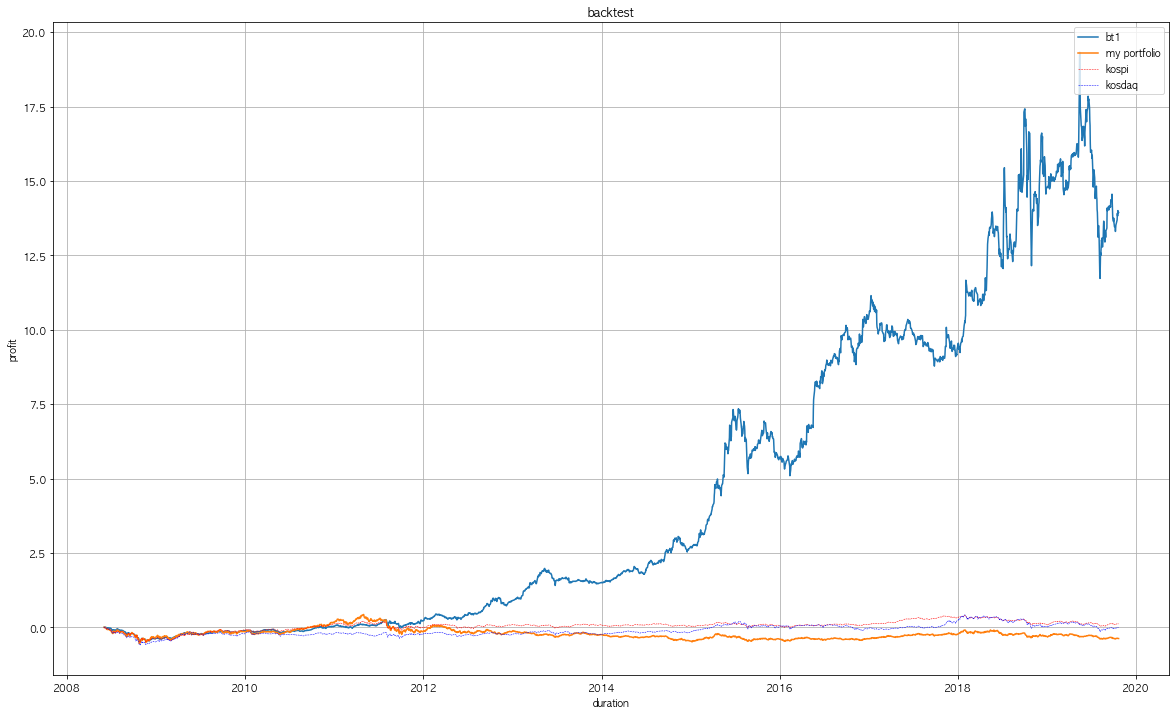

In [25]:
plt.rc('font', size=10)
plt.figure(figsize=(20, 12))
plt.plot(bt1.index, bt1['total_change_rate'], label='bt1')
# plt.plot(bt2.index, bt2['total_change_rate'], label='bt2')
# plt.plot(bt3.index, bt3['total_change_rate'], label='bt3')
plt.plot(my.index, my['total_change_rate'], label='my portfolio')
# plt.plot(samsung.index, samsung['total_change_rate'], label='samsung')
plt.plot(kospi_df.index, kospi_df['total_change_rate'], label='kospi', color='red',linewidth=0.5, linestyle='dashed')
plt.plot(kosdaq_df.index, kosdaq_df['total_change_rate'], label='kosdaq', color='blue',linewidth=0.5, linestyle='dashed')
plt.title('backtest')
plt.xlabel("duration")
plt.ylabel("profit")
plt.legend(loc='upper right')
plt.grid()
plt.show()